<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/TestBench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
IN_COLAB = True

output_dir = 'results/'

try:
  import google.colab
  # Using Google Drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Dataset download and extraction
  !unzip -qq drive/MyDrive/cern/data/rich.zip

  # Model checkpoint download and extraction
  !unzip -qq drive/MyDrive/cern/data/checkpoints_dropout_0.01.zip

  # Model embeddings download and extraction
  !unzip -qq drive/MyDrive/cern/data/embeddings.zip

  # Results folder creation
  !mkdir /content/drive/MyDrive/cern/data/results

  output_dir = f'/content/drive/MyDrive/cern/data/{output_dir}'

except:
  IN_COLAB = False

print(f'IN_COLAB: {IN_COLAB}')

Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/MyDrive/cern/data/results’: File exists
IN_COLAB: True


In [ ]:
!git clone https://github.com/evillag/uncertainty_gan.git
!mv uncertainty_gan/mcd .
!mv uncertainty_gan/feature_densities .
!mv uncertainty_gan/test_bench .
%rm -rf uncertainty_gan/

!git clone https://gitlab.com/lambda-hse/lhcb-rich-gan-uncertainty.git
!mv lhcb-rich-gan-uncertainty/experiments .
!mv lhcb-rich-gan-uncertainty/src .
%rm -rf lhcb-rich-gan-uncertainty/
%rm -rf sample_data/
%pip install tensorflow-addons

Cloning into 'uncertainty_gan'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 186 (delta 18), reused 4 (delta 3), pack-reused 147
Receiving objects: 100% (186/186), 22.63 MiB | 18.81 MiB/s, done.
Resolving deltas: 100% (94/94), done.
Cloning into 'lhcb-rich-gan-uncertainty'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210 (from 1)
Receiving objects: 100% (210/210), 2.94 MiB | 28.15 MiB/s, done.
Resolving deltas: 100% (94/94), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.5 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from test_bench import get_checkpoint_name, load_particle_datasets, subsample_dataset
from test_bench.model import MonteCarloDropoutModel

# Test Bench for the Monte Carlo Dropout and Feature Density methods

1. Select sample data
2. Create a model
3. Generate a single target with single inference mode
4. Estimate MCD uncertainty
5. Estimate FD uncertainty

In [5]:
# Parameters
PARTICLE = 'pion'
CHECKPOINT_DP = 0.01
DROPOUT_TYPE = 'bernoulli_structured'
CHECKPOINT_BASE = 'checkpoints/'
DATA_DIR = 'rich/'
SUB_SAMPLE_SIZE = 100000
DLL_COLUMNS = ['RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']

# MCD parameters
MCD_ENSEMBLE_SIZE = 300

# FD parameters
embeddings_dir = f'embeddings/'

# Load results (Optional)

Uncomment to load previous execution results.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
output_dir = f'/content/drive/MyDrive/cern/data/results/'

x_sample = np.load(output_dir + f'{PARTICLE}_x_sample.npy')
y_sample = np.load(output_dir + f'{PARTICLE}_y_sample.npy')
t_generated = np.load(output_dir + f'{PARTICLE}_t_generated.npy')

mcd_uncertainty = np.load(output_dir + f'{PARTICLE}_mcd_uncertainty.npy')
fd_uncertainty_normalized = np.load(output_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy')
#fd_uncertainty_integration = np.load(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy')

# Load data and Sample selection

In [ ]:
dataset = load_particle_datasets(PARTICLE, DATA_DIR)

Reading and concatenating datasets:
	rich/pion2_-_down_2016_.csv
	rich/pion_+_down_2016_.csv
	rich/pion2_-_up_2016_.csv
	rich/pion2_+_up_2016_.csv
	rich/pion_-_up_2016_.csv
	rich/pion_-_down_2016_.csv
	rich/pion2_+_down_2016_.csv
	rich/pion_+_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 1.842810869216919
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>
feats_train shape	(948292, 3)
targets_train shape	(948292, 5)
feats_val shape  	(525967, 3)
targets_val shape	(525967, 5)



In [ ]:
# Draw a sample of the datasets
x_sample, y_sample = subsample_dataset(dataset['feats_val'], dataset['targets_val'], SUB_SAMPLE_SIZE / dataset['feats_val'].shape[0])
x_sample.shape, y_sample.shape

(TensorShape([100000, 3]), TensorShape([100000, 5]))

# Model creation

In [ ]:
model = MonteCarloDropoutModel(
    PARTICLE,
    dropout_rate=CHECKPOINT_DP,
    checkpoint_dir=CHECKPOINT_BASE + get_checkpoint_name(PARTICLE, CHECKPOINT_DP, DROPOUT_TYPE),
    debug=True
)
generator = model.get_generator()

Generating model for pion with a dropout rate of 0.01
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4

Generator:

Model: "virtual_ensemble_model"
________________________________________________________________________________________________
 Layer (type)                              Output Shape                          Param #        
 Inputs (InputLayer)                       [(None, 3)]                           0              
                                                                                                
 NoiseInjection (NoiseInjection)           (None, 67)                            0              
                                                                                                
 Layer_0/Dense (Dense)                     (None, 128)                           8704           
                                                                                                
 Layer_0/LeakyReLU (LeakyReLU)             (None, 128)                           0   

## Single model prediction

In [ ]:
generator.single_model_inference_mode()
t_generated = generator.predict(x_sample)
t_generated.shape

3125/3125 [==============================] - 13s 3ms/step


(100000, 5)

In [ ]:
# Save real and generated targets
np.save(output_dir + f'{PARTICLE}_x_real.npy', x_sample)
np.save(output_dir + f'{PARTICLE}_y_real.npy', y_sample)
np.save(output_dir + f'{PARTICLE}_t_generated.npy', t_generated)

### Plotting functions

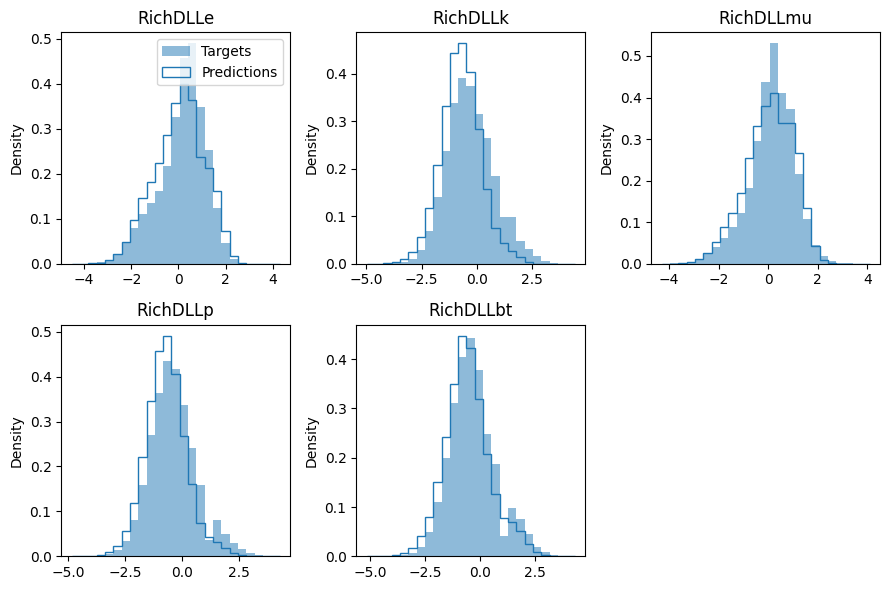

In [7]:
def plot_target_histrogams(real_targets, generated_targets, dll_columns=DLL_COLUMNS):
  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    particle_targets = np.array(real_targets[:, i])
    particle_predictions = np.array(generated_targets[:, i])

    mins = particle_targets.min(), particle_predictions.min()
    maxs = particle_targets.max(), particle_predictions.max()

    hist_range = min(mins), max(maxs)

    ax.set_title(dll_columns[i])
    ax.hist(particle_targets, 25, hist_range, True, alpha=.5, label='Targets')
    ax.hist(particle_predictions, 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')
    ax.set_ylabel('Density')

  axes[0, 0].legend()
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

plot_target_histrogams(y_sample, t_generated)

The problem with `estimate_distances_and_plot_uncertainty_bins` is that it splits the data in unbalnced bins, with different sizes, some bins could get up to 30k samples while others get less than 20. Instead binning by quantiles generates a balanced number of observations per bin.

In [22]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import linregress

def estimate_distances_and_plot_uncertainty_bins(y_real, y_generated, uncertainty_scores, uncertainty_type = None, bin_type = 'linear',
                                                 particle_index = 0, n_rows = 2, n_cols = 5, dll_columns=DLL_COLUMNS):
  n_bins = n_rows * n_cols

  targets = np.array(y_real[:, particle_index])
  predictions = np.array(y_generated[:, particle_index])
  uncertainty_scores = np.array(uncertainty_scores)

  if uncertainty_type == 'MCD':
    uncertainty_scores = uncertainty_scores[:, particle_index]

  if bin_type == 'linear':
    bin_edges = np.linspace(uncertainty_scores.min(), uncertainty_scores.max(), n_bins + 1)
  else: # Quantiles
    bin_edges = np.quantile(uncertainty_scores, np.linspace(0, 1, n_bins + 1))

  # Digitize returns sample indices per bin
  bin_indices = np.digitize(uncertainty_scores, bin_edges)

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

  rounded_bin_edges = np.round(bin_edges, 2)

  js_distances = []

  for i, ax in enumerate(axes.flatten()):
    indices = bin_indices == i + 1

    mins = targets[indices].min(), predictions[indices].min()
    maxs = targets[indices].max(), predictions[indices].max()

    hist_range = min(mins), max(maxs)

    targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
    predictions_hist = ax.hist(
        predictions[indices], 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')[0]

    ax.set_xlabel(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}', bbox={'facecolor': 'none'})

    js_dist = jensenshannon(predictions_hist, targets_hist)
    js_distances += [js_dist]
    print(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}: Number of observations: {len(predictions[indices])}')

  plt.suptitle(f'{uncertainty_type} uncertainty score bins for {dll_columns[particle_index]}')
  axes[0, 0].legend()
  plt.tight_layout()
  plt.show()
  print("Jensen–Shannon distances:\n" + ", ".join([str(dist) for dist in js_distances]))

  return bin_edges, js_distances


def plot_distances(bin_ranges, distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0):
  bin_ranges = np.mean([bin_ranges[1:], bin_ranges[:-1]], 0)

  plt.title(f'{uncertainty_type} reliability curve for {dll_columns[particle_index]}')
  plt.gca().set_axisbelow(True)
  plt.grid()
  plt.plot(bin_ranges, distances, '.-')
  plt.xlabel('Uncertainty score')
  plt.ylabel('Jensen–Shannon distance')
  plt.show()

  print('Correlation coefficient:', linregress(bin_ranges, distances).rvalue)

def plot_all_distances(all_bin_ranges, all_distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0):
  plt.title(f'{uncertainty_type} reliability curves')
  plt.gca().set_axisbelow(True)
  plt.grid()

  for i in range(5):
    bin_ranges = np.mean([all_bin_ranges[i][1:], all_bin_ranges[i][:-1]], 0)
    plt.plot(bin_ranges, all_distances[i], '.-', label=dll_columns[i])
    regress = linregress(bin_ranges, all_distances[i])
    print(f'Correlation coefficient for {dll_columns[i]}:', regress.rvalue)

  plt.xlabel('Uncertainty score')
  plt.ylabel('Jensen–Shannon distance')
  plt.legend()
  plt.show()

## Monte Carlo Dropout method

In [ ]:
from mcd.MCDEvaluator import evaluate_model as mcd_evaluate_model

mcd_uncertainty = mcd_evaluate_model(model, x_sample, MCD_ENSEMBLE_SIZE)[0]
mcd_uncertainty.shape

Generating ensemble(300) predictions


100%|██████████| 300/300 [00:11<00:00, 26.77it/s]


TensorShape([100000, 5])

In [ ]:
# Save MCD uncertainties
np.save(output_dir + f'{PARTICLE}_mcd_uncertainty.npy', mcd_uncertainty)

### Plot MCD uncertainties

#### Linear bins

0.05 < unc. score < 0.11: Number of observations: 3756
0.11 < unc. score < 0.17: Number of observations: 6966
0.17 < unc. score < 0.23: Number of observations: 6677
0.23 < unc. score < 0.29: Number of observations: 10437
0.29 < unc. score < 0.35: Number of observations: 25761
0.35 < unc. score < 0.41: Number of observations: 31128
0.41 < unc. score < 0.47: Number of observations: 12498
0.47 < unc. score < 0.54: Number of observations: 2436
0.54 < unc. score < 0.6: Number of observations: 305
0.6 < unc. score < 0.66: Number of observations: 35


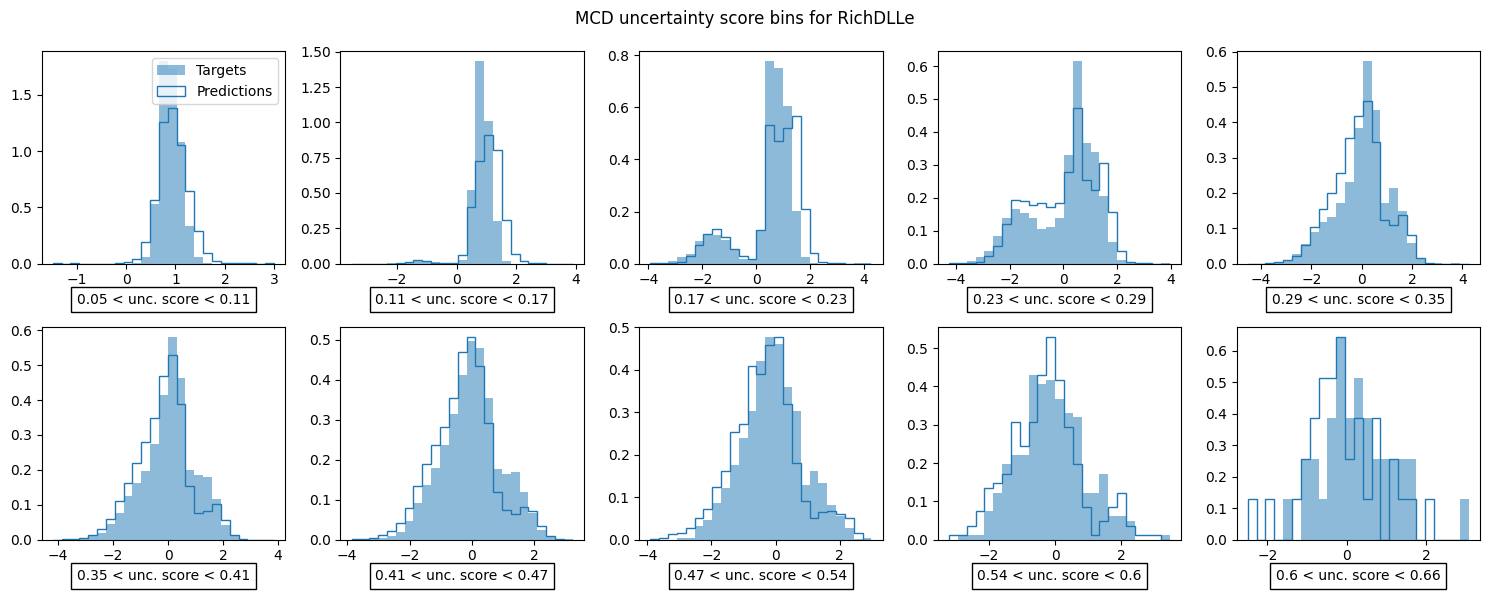

Jensen–Shannon distances:
0.1814288968164638, 0.26641612570684653, 0.21132540323823917, 0.13506264142415997, 0.11075730025263669, 0.11298924543715186, 0.11272456584182272, 0.13405953912347138, 0.17592218118027367, 0.3341797403581878
0.0 < unc. score < 0.1: Number of observations: 272
0.1 < unc. score < 0.2: Number of observations: 490
0.2 < unc. score < 0.3: Number of observations: 14060
0.3 < unc. score < 0.4: Number of observations: 31999
0.4 < unc. score < 0.5: Number of observations: 33960
0.5 < unc. score < 0.6: Number of observations: 15215
0.6 < unc. score < 0.7: Number of observations: 3372
0.7 < unc. score < 0.8: Number of observations: 551
0.8 < unc. score < 0.9: Number of observations: 76
0.9 < unc. score < 1.0: Number of observations: 4


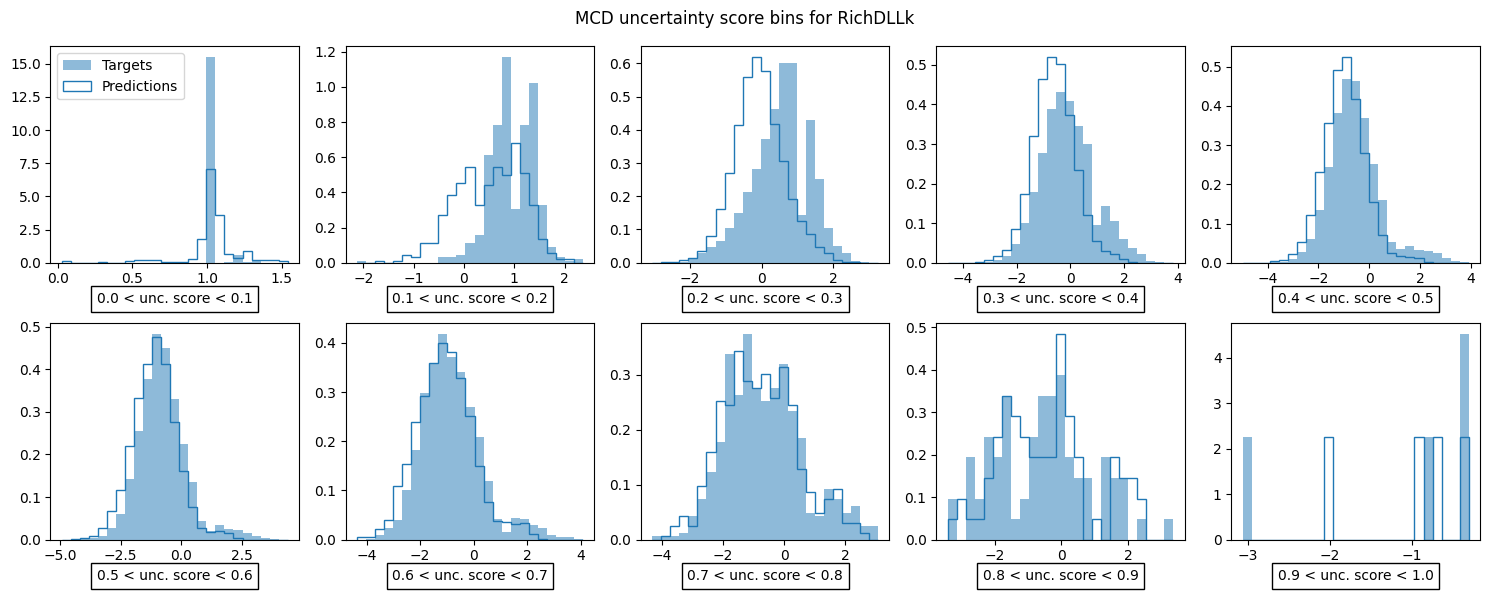

Jensen–Shannon distances:
0.47546271972979937, 0.3570408512906257, 0.3003615532037294, 0.20831955712430136, 0.1654732454165683, 0.12772691368828898, 0.11832217720524695, 0.11648917648768815, 0.3190398189744509, 0.6741322730850806
0.0 < unc. score < 0.11: Number of observations: 9781
0.11 < unc. score < 0.22: Number of observations: 11762
0.22 < unc. score < 0.32: Number of observations: 12161
0.32 < unc. score < 0.43: Number of observations: 13583
0.43 < unc. score < 0.54: Number of observations: 18682
0.54 < unc. score < 0.64: Number of observations: 20995
0.64 < unc. score < 0.75: Number of observations: 10048
0.75 < unc. score < 0.86: Number of observations: 2591
0.86 < unc. score < 0.96: Number of observations: 364
0.96 < unc. score < 1.07: Number of observations: 32


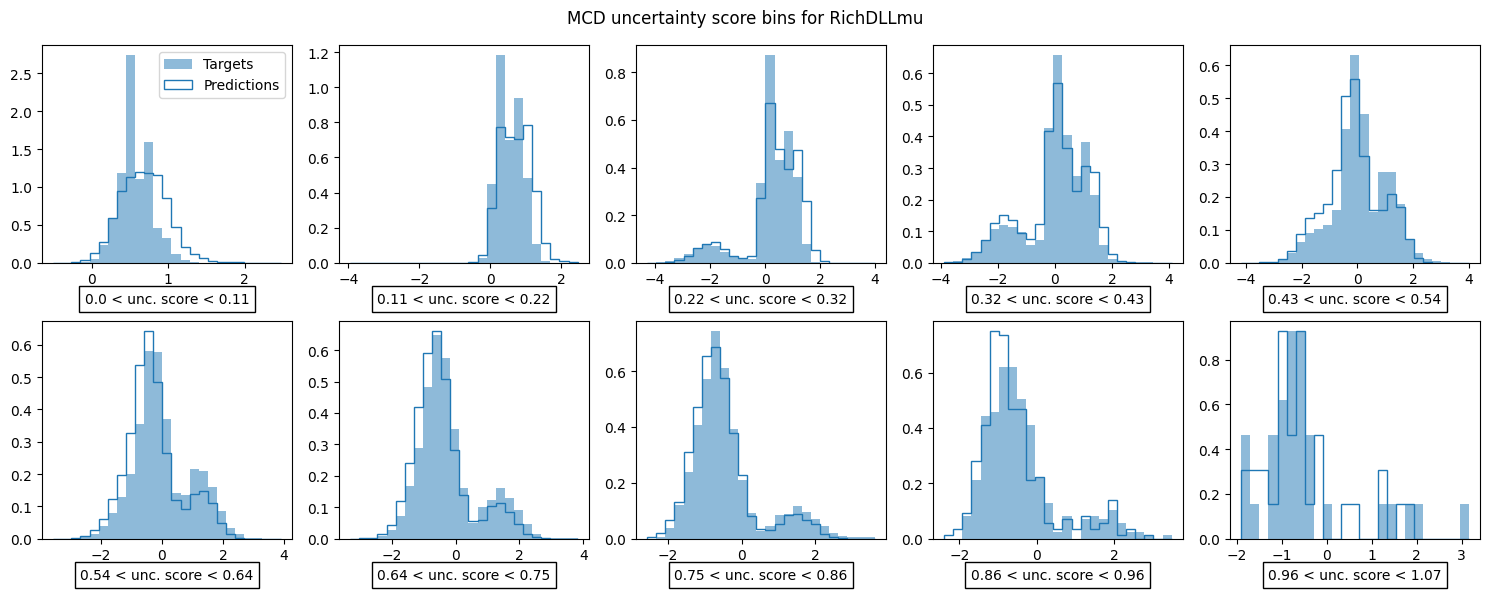

Jensen–Shannon distances:
0.24830305434961278, 0.19001681899754744, 0.14646154999712105, 0.08282462696539772, 0.11453679999232563, 0.12481746686223251, 0.10549157302046831, 0.0850040734753775, 0.1601159708593336, 0.40535074238986785
0.0 < unc. score < 0.12: Number of observations: 303
0.12 < unc. score < 0.23: Number of observations: 772
0.23 < unc. score < 0.35: Number of observations: 8386
0.35 < unc. score < 0.47: Number of observations: 34207
0.47 < unc. score < 0.58: Number of observations: 36066
0.58 < unc. score < 0.7: Number of observations: 15168
0.7 < unc. score < 0.81: Number of observations: 3930
0.81 < unc. score < 0.93: Number of observations: 949
0.93 < unc. score < 1.05: Number of observations: 196
1.05 < unc. score < 1.16: Number of observations: 22


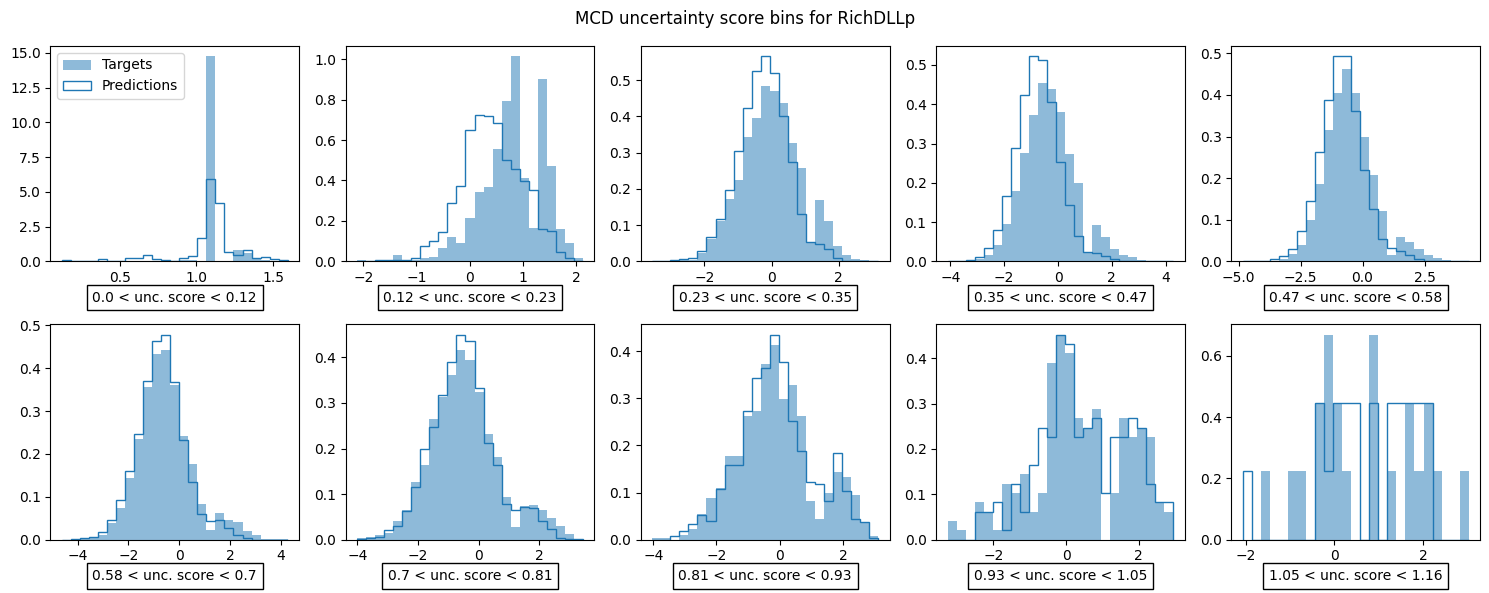

Jensen–Shannon distances:
0.48007899386693553, 0.30230222640932425, 0.1338372324831429, 0.18618926135637348, 0.13554417612155406, 0.08638448748700091, 0.0778353642051228, 0.10677643957875178, 0.1983724567369326, 0.42813270408807313
0.0 < unc. score < 0.2: Number of observations: 532
0.2 < unc. score < 0.39: Number of observations: 7568
0.39 < unc. score < 0.59: Number of observations: 32484
0.59 < unc. score < 0.78: Number of observations: 27827
0.78 < unc. score < 0.98: Number of observations: 19002
0.98 < unc. score < 1.17: Number of observations: 9520
1.17 < unc. score < 1.37: Number of observations: 2647
1.37 < unc. score < 1.56: Number of observations: 367
1.56 < unc. score < 1.76: Number of observations: 47
1.76 < unc. score < 1.95: Number of observations: 5


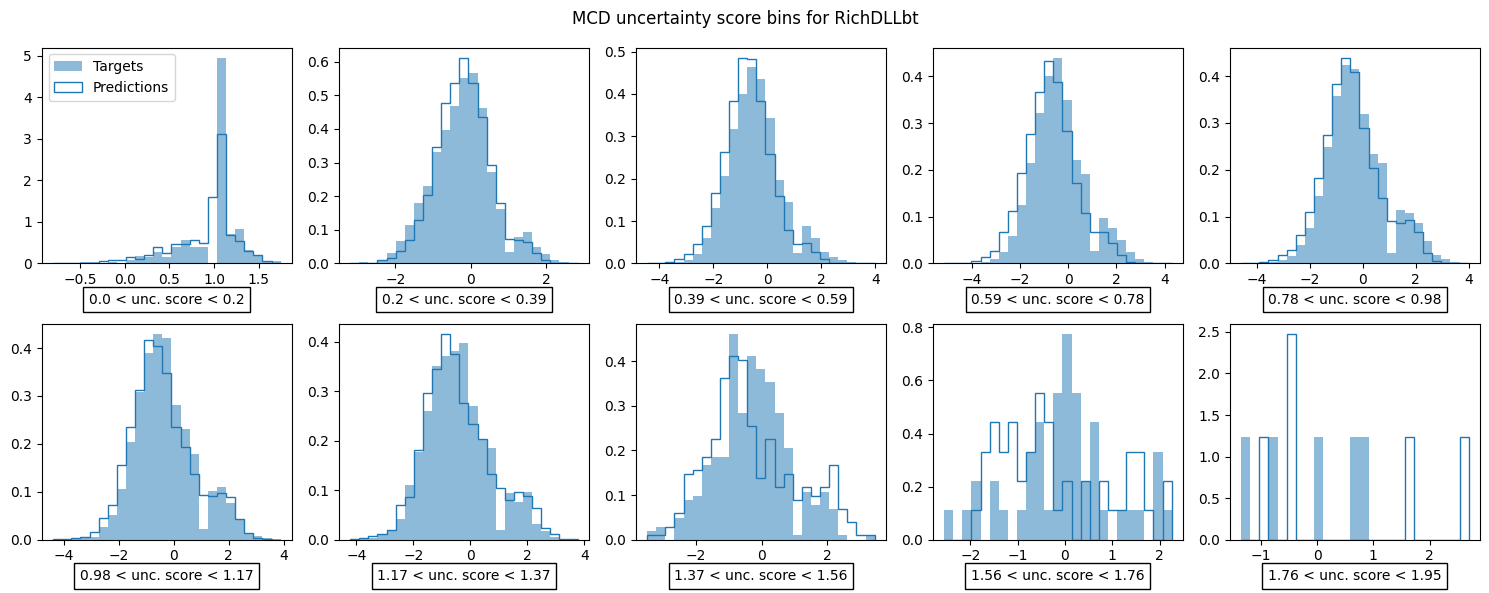

Jensen–Shannon distances:
0.28272357571749357, 0.07410148169793107, 0.11572313299170153, 0.13909110976393693, 0.10407845518755696, 0.0931541621238457, 0.10375625102406429, 0.21597357688584257, 0.48900030790550497, 0.8325546111576977


In [33]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', particle_index = i)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

Correlation coefficient for RichDLLe: 0.07135615510841885
Correlation coefficient for RichDLLk: 0.02987293405798278
Correlation coefficient for RichDLLmu: 0.18247094052325397
Correlation coefficient for RichDLLp: -0.21852919836025037
Correlation coefficient for RichDLLbt: 0.6246001448197979


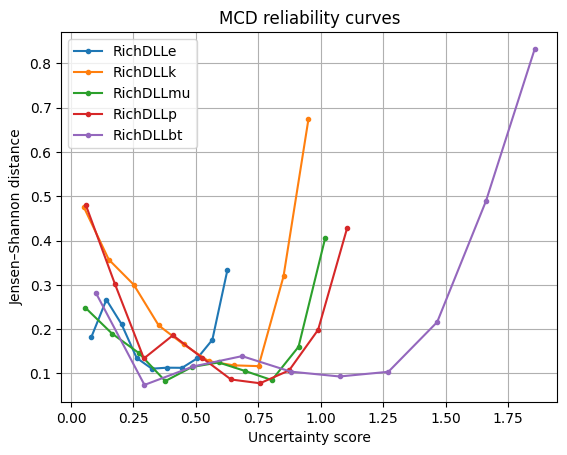

In [34]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD')

#### Quantile bins

0.05 < unc. score < 0.16: Number of observations: 10000
0.16 < unc. score < 0.25: Number of observations: 10000
0.25 < unc. score < 0.3: Number of observations: 10000
0.3 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.35: Number of observations: 10000
0.35 < unc. score < 0.36: Number of observations: 10000
0.36 < unc. score < 0.38: Number of observations: 10000
0.38 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.43: Number of observations: 10000
0.43 < unc. score < 0.66: Number of observations: 9999


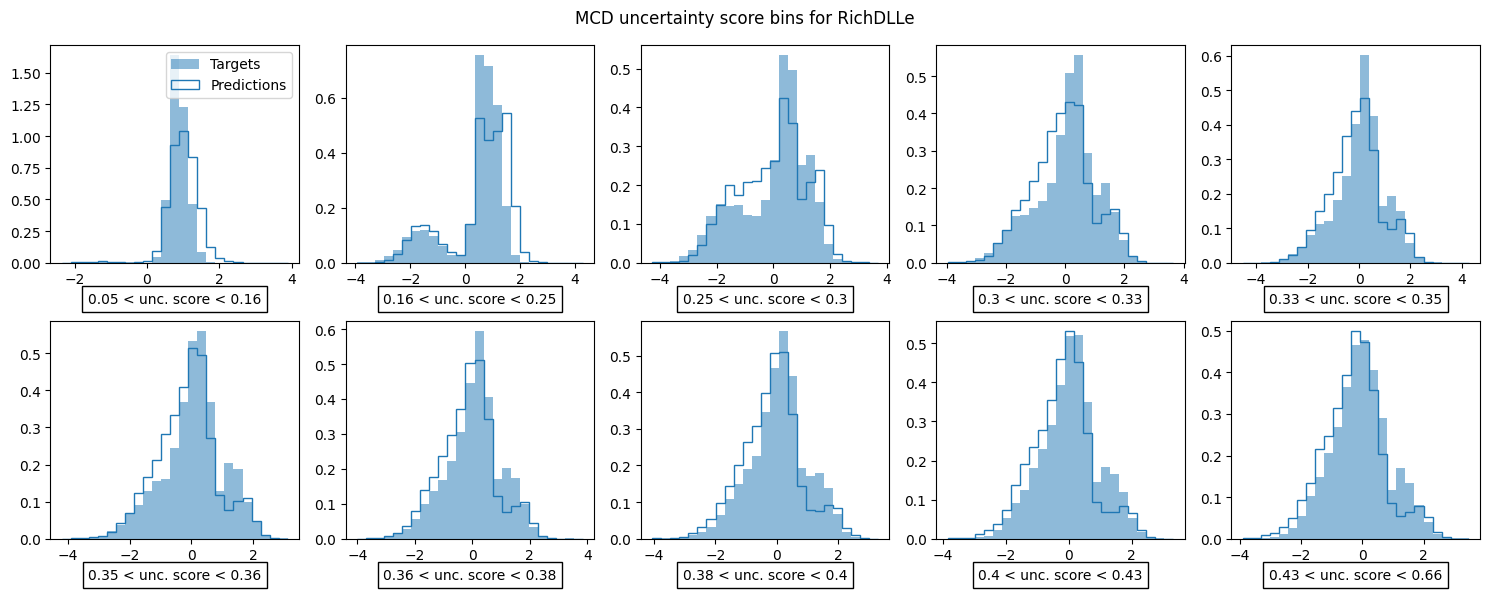

Jensen–Shannon distances:
0.22879861784615846, 0.20283963017555448, 0.12725723563388752, 0.11414178884405823, 0.11228747674886308, 0.11321428399466571, 0.11210348349191193, 0.11449966121044129, 0.12077721382829384, 0.11491708235380303
0.0 < unc. score < 0.28: Number of observations: 10000
0.28 < unc. score < 0.32: Number of observations: 10000
0.32 < unc. score < 0.35: Number of observations: 10000
0.35 < unc. score < 0.38: Number of observations: 10000
0.38 < unc. score < 0.41: Number of observations: 10000
0.41 < unc. score < 0.44: Number of observations: 10000
0.44 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.5: Number of observations: 10000
0.5 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 1.0: Number of observations: 9999


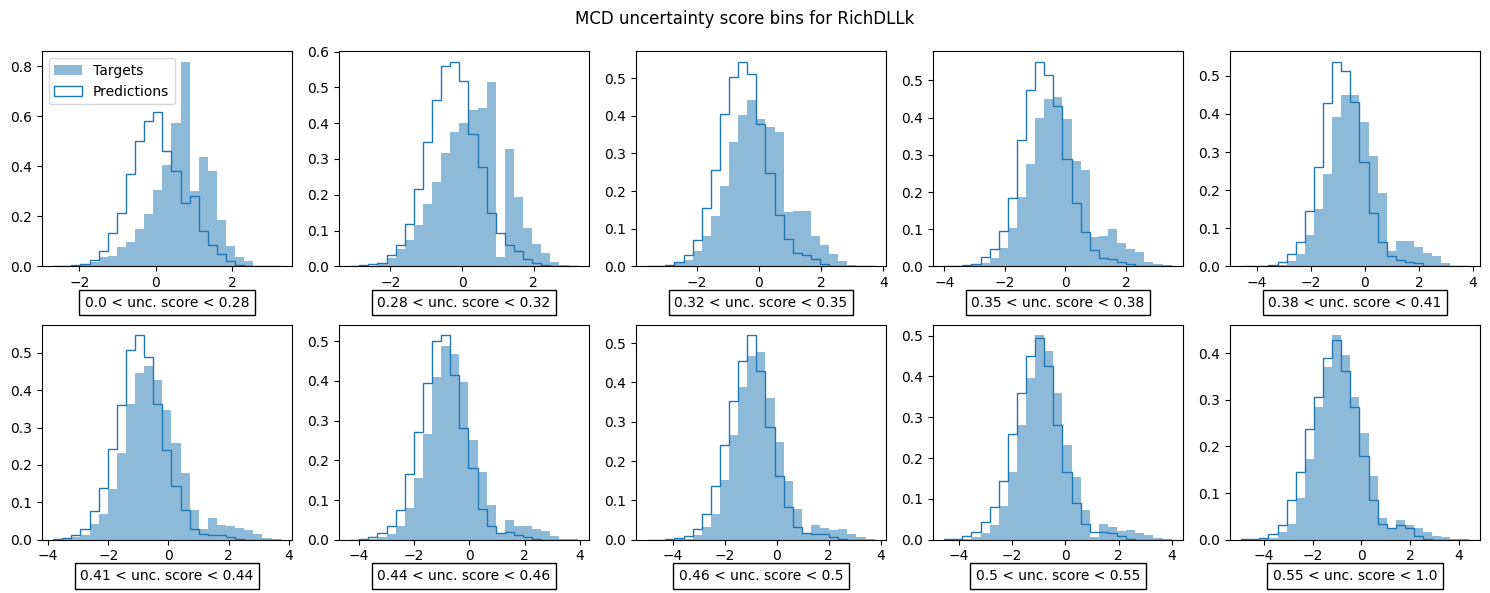

Jensen–Shannon distances:
0.314221187607097, 0.25995823759134, 0.2183512930719278, 0.2052802094667484, 0.20245973884566287, 0.18037767498987675, 0.16855556181709247, 0.1496041669850758, 0.14057364718527748, 0.11069460941979907
0.0 < unc. score < 0.11: Number of observations: 10000
0.11 < unc. score < 0.2: Number of observations: 10000
0.2 < unc. score < 0.29: Number of observations: 10000
0.29 < unc. score < 0.38: Number of observations: 10000
0.38 < unc. score < 0.45: Number of observations: 10000
0.45 < unc. score < 0.51: Number of observations: 10000
0.51 < unc. score < 0.56: Number of observations: 10000
0.56 < unc. score < 0.6: Number of observations: 10000
0.6 < unc. score < 0.67: Number of observations: 10000
0.67 < unc. score < 1.07: Number of observations: 9999


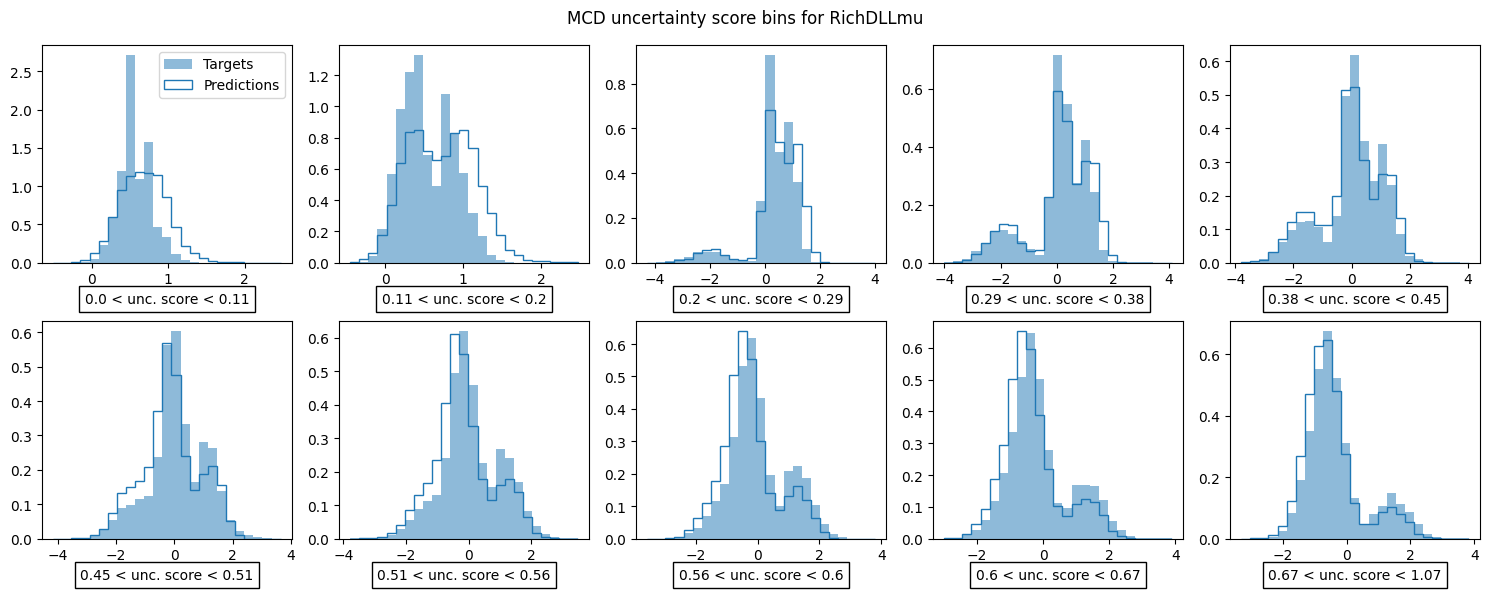

Jensen–Shannon distances:
0.24600188949135324, 0.20384952600706244, 0.1602304977045465, 0.10293343662507237, 0.0825413742933149, 0.11205402552885688, 0.12343867747653971, 0.13104226779328587, 0.11748610357958235, 0.09543114663786434
0.0 < unc. score < 0.35: Number of observations: 10000
0.35 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.43: Number of observations: 10000
0.43 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.48: Number of observations: 10000
0.48 < unc. score < 0.51: Number of observations: 10000
0.51 < unc. score < 0.54: Number of observations: 10000
0.54 < unc. score < 0.58: Number of observations: 10000
0.58 < unc. score < 0.64: Number of observations: 10000
0.64 < unc. score < 1.16: Number of observations: 9999


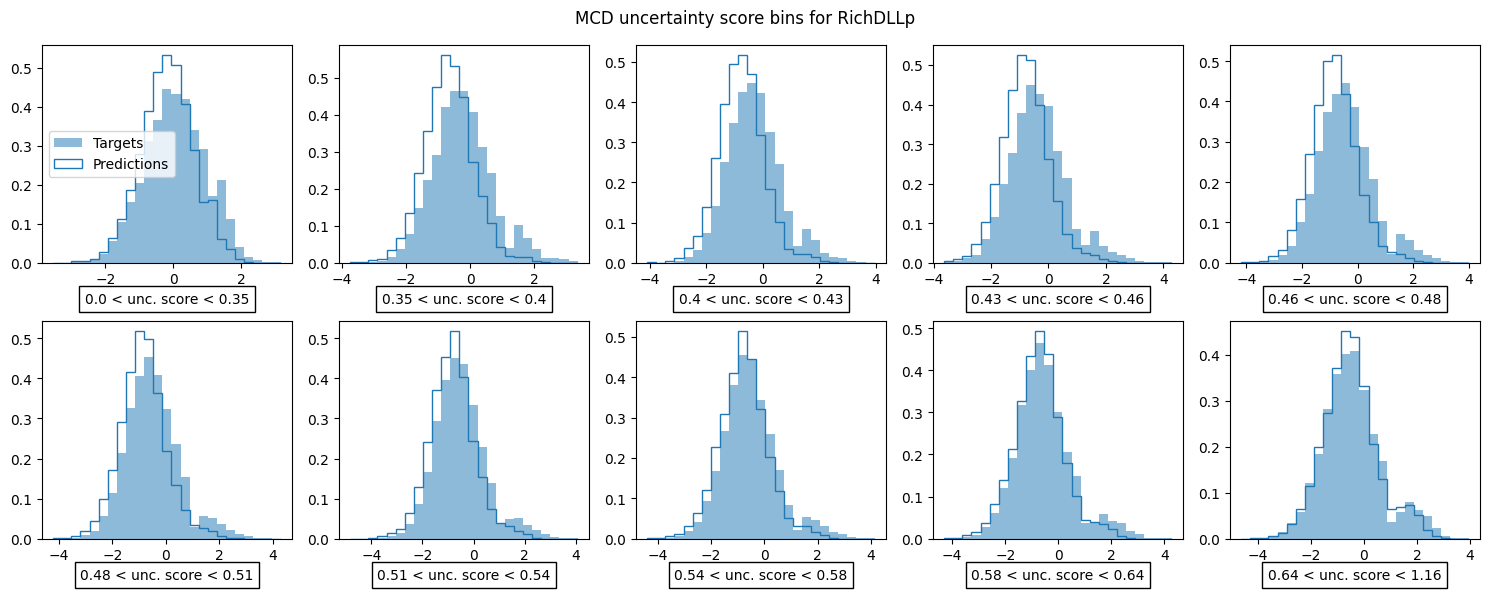

Jensen–Shannon distances:
0.1369021542141829, 0.19052883105221247, 0.19276455991406843, 0.18551759165536919, 0.16771876768717353, 0.14797301843509217, 0.12538010915724726, 0.10755547936887017, 0.0917036823731287, 0.06627039518238759
0.0 < unc. score < 0.41: Number of observations: 10000
0.41 < unc. score < 0.47: Number of observations: 10000
0.47 < unc. score < 0.53: Number of observations: 10000
0.53 < unc. score < 0.58: Number of observations: 10000
0.58 < unc. score < 0.64: Number of observations: 10000
0.64 < unc. score < 0.71: Number of observations: 10000
0.71 < unc. score < 0.8: Number of observations: 10000
0.8 < unc. score < 0.89: Number of observations: 10000
0.89 < unc. score < 1.01: Number of observations: 10000
1.01 < unc. score < 1.95: Number of observations: 9999


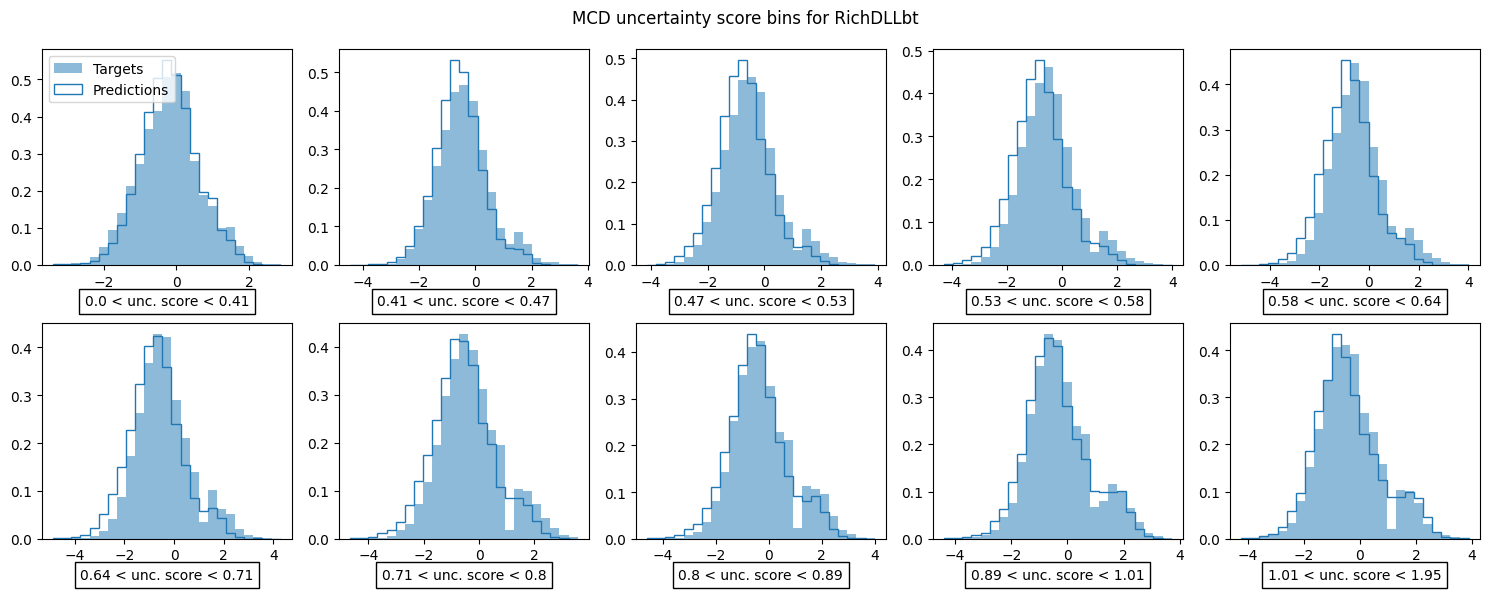

Jensen–Shannon distances:
0.0664549304365875, 0.0865328156278637, 0.12311270190113643, 0.14137375455090267, 0.14201413555391185, 0.13421702044513265, 0.13471604688823874, 0.11192885253558886, 0.07134621014792066, 0.0895083369773378


In [27]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', bin_type='quantiles', particle_index = i)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

Correlation coefficient for RichDLLe: -0.8086811247811561
Correlation coefficient for RichDLLk: -0.9358471181379824
Correlation coefficient for RichDLLmu: -0.7533969035435436
Correlation coefficient for RichDLLp: -0.695385965699003
Correlation coefficient for RichDLLbt: -0.07533603300321838


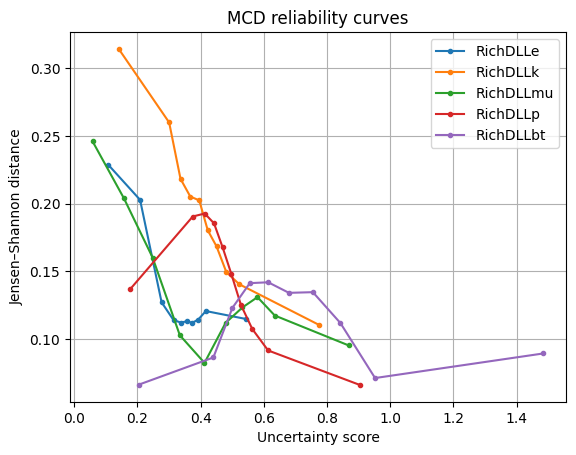

In [28]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD')

## Feature Densities method

### Uncertainty estimation

In [ ]:
from feature_densities.feature_density_evaluator import evaluate_model as fd_evaluate_model

train_embeddings = np.load(embeddings_dir + f'{PARTICLE}_train_embeddings.npy')
train_embeddings.shape

(948325, 128)

In [ ]:
fd_uncertainty_normalized, _ = fd_evaluate_model(model, x_sample, known_embeddings=train_embeddings, n_fit_samples=100,
                                                 likelihood_method='normalized')

print('Feature Densities using NORMALIZED uncertainty score for x_sample:')
fd_uncertainty_normalized.shape

Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 11s 3ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:35<00:00,  3.64it/s]


Feature Densities using NORMALIZED uncertainty score for x_sample:


TensorShape([100000])

In [ ]:
# Save FD uncertainties normalized
np.save(output_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy', fd_uncertainty_normalized)

### Plot FD uncertainties

#### Linear bins

0.06 < unc. score < 0.15: Number of observations: 1153
0.15 < unc. score < 0.24: Number of observations: 4438
0.24 < unc. score < 0.33: Number of observations: 6767
0.33 < unc. score < 0.42: Number of observations: 9720
0.42 < unc. score < 0.51: Number of observations: 13626
0.51 < unc. score < 0.6: Number of observations: 17432
0.6 < unc. score < 0.69: Number of observations: 18766
0.69 < unc. score < 0.78: Number of observations: 15394
0.78 < unc. score < 0.87: Number of observations: 10854
0.87 < unc. score < 0.95: Number of observations: 1849


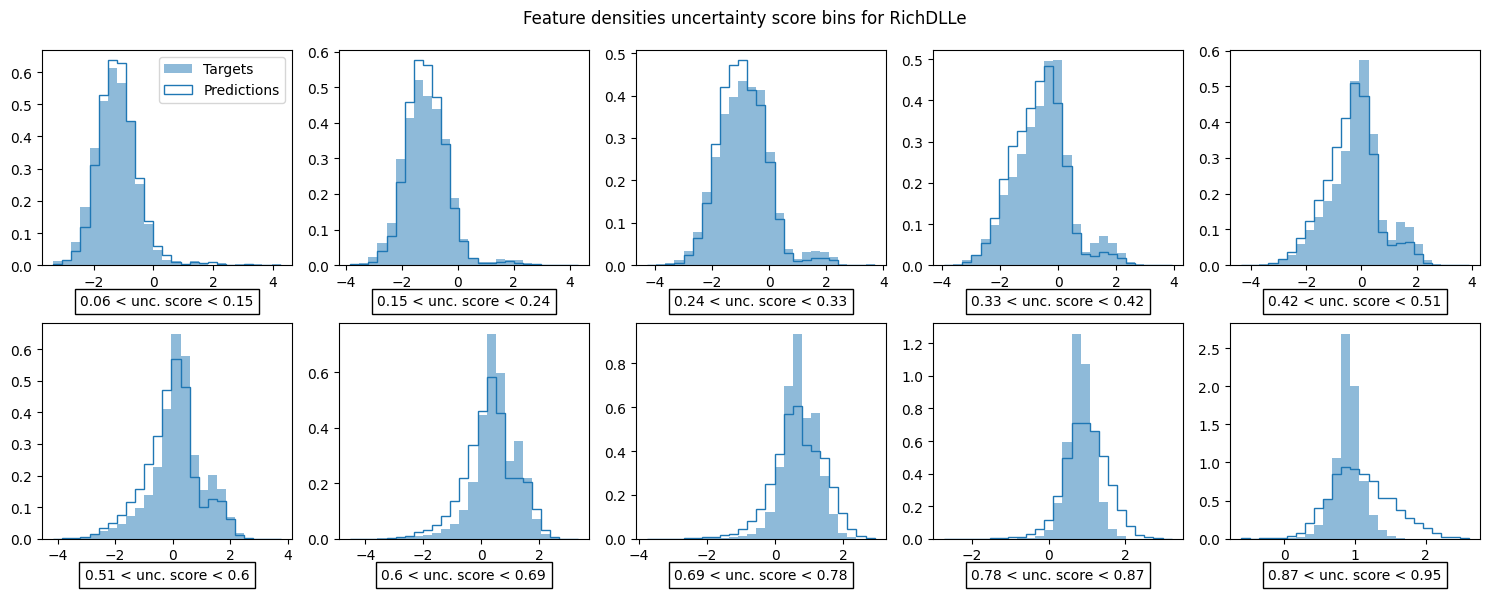

Jensen–Shannon distances:
0.07478968752777065, 0.06813111684825568, 0.07130779896354067, 0.08579282987992523, 0.09937391906951887, 0.10777866415683117, 0.13911224136290137, 0.17708772124000788, 0.23642270722931413, 0.36259205113919407
0.06 < unc. score < 0.15: Number of observations: 1153
0.15 < unc. score < 0.24: Number of observations: 4438
0.24 < unc. score < 0.33: Number of observations: 6767
0.33 < unc. score < 0.42: Number of observations: 9720
0.42 < unc. score < 0.51: Number of observations: 13626
0.51 < unc. score < 0.6: Number of observations: 17432
0.6 < unc. score < 0.69: Number of observations: 18766
0.69 < unc. score < 0.78: Number of observations: 15394
0.78 < unc. score < 0.87: Number of observations: 10854
0.87 < unc. score < 0.95: Number of observations: 1849


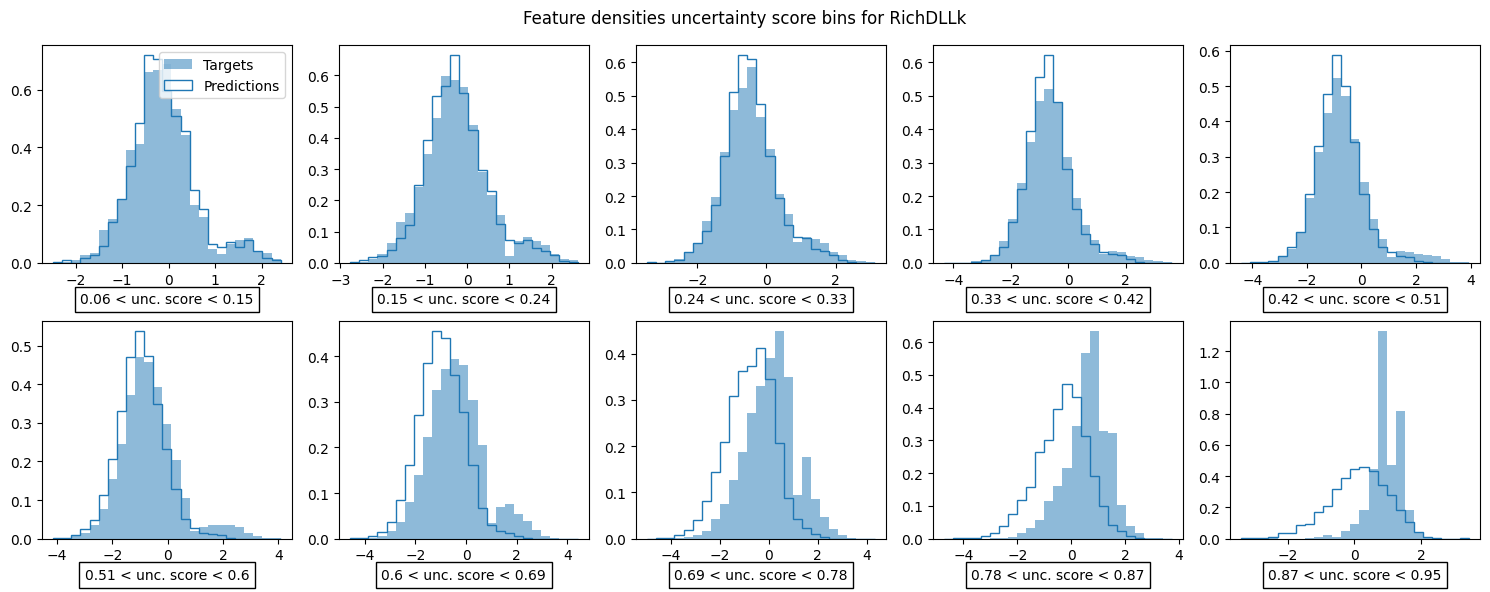

Jensen–Shannon distances:
0.06732722170126502, 0.07077475950813648, 0.06795751024121886, 0.07765201388608957, 0.09712534523186787, 0.1393427050930597, 0.21734967270632705, 0.29452521252316805, 0.363037880221817, 0.44034464516367755
0.06 < unc. score < 0.15: Number of observations: 1153
0.15 < unc. score < 0.24: Number of observations: 4438
0.24 < unc. score < 0.33: Number of observations: 6767
0.33 < unc. score < 0.42: Number of observations: 9720
0.42 < unc. score < 0.51: Number of observations: 13626
0.51 < unc. score < 0.6: Number of observations: 17432
0.6 < unc. score < 0.69: Number of observations: 18766
0.69 < unc. score < 0.78: Number of observations: 15394
0.78 < unc. score < 0.87: Number of observations: 10854
0.87 < unc. score < 0.95: Number of observations: 1849


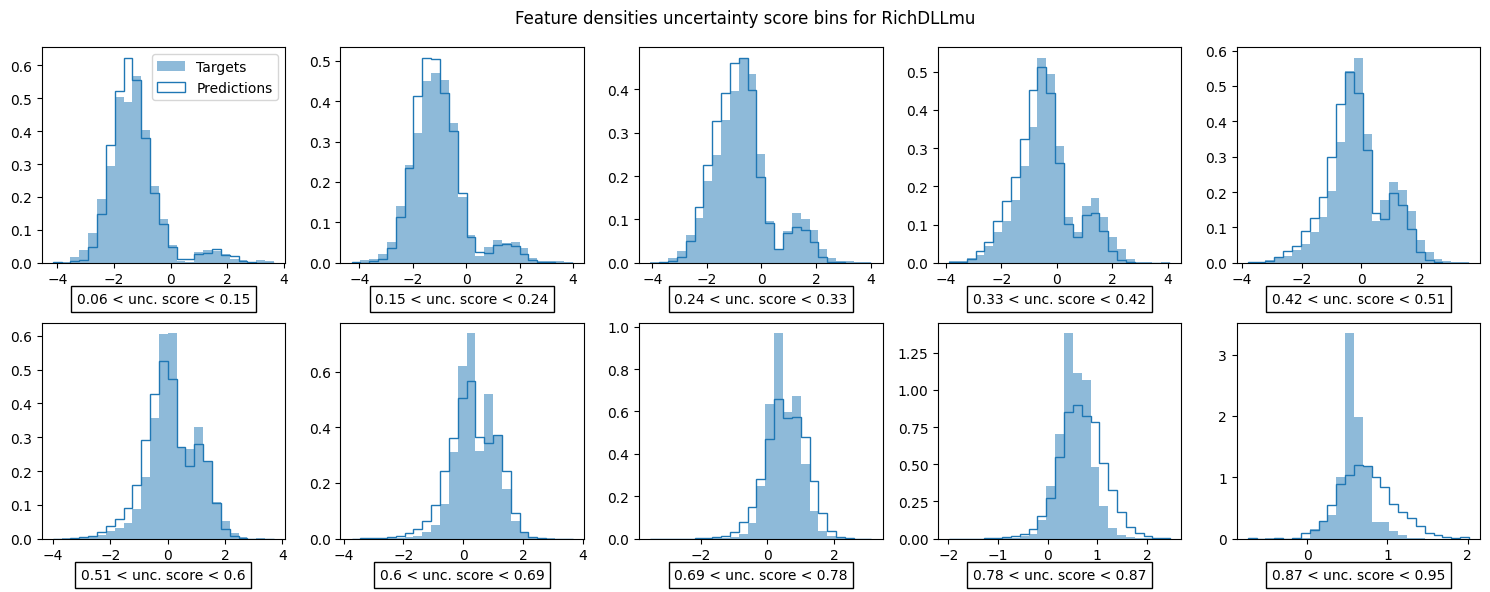

Jensen–Shannon distances:
0.09597202648009705, 0.07460586375537673, 0.08424627249483928, 0.09522190004885646, 0.10532705935023202, 0.10262761814939043, 0.12456822013308474, 0.14779692253647325, 0.19575615935641869, 0.3306894503213564
0.06 < unc. score < 0.15: Number of observations: 1153
0.15 < unc. score < 0.24: Number of observations: 4438
0.24 < unc. score < 0.33: Number of observations: 6767
0.33 < unc. score < 0.42: Number of observations: 9720
0.42 < unc. score < 0.51: Number of observations: 13626
0.51 < unc. score < 0.6: Number of observations: 17432
0.6 < unc. score < 0.69: Number of observations: 18766
0.69 < unc. score < 0.78: Number of observations: 15394
0.78 < unc. score < 0.87: Number of observations: 10854
0.87 < unc. score < 0.95: Number of observations: 1849


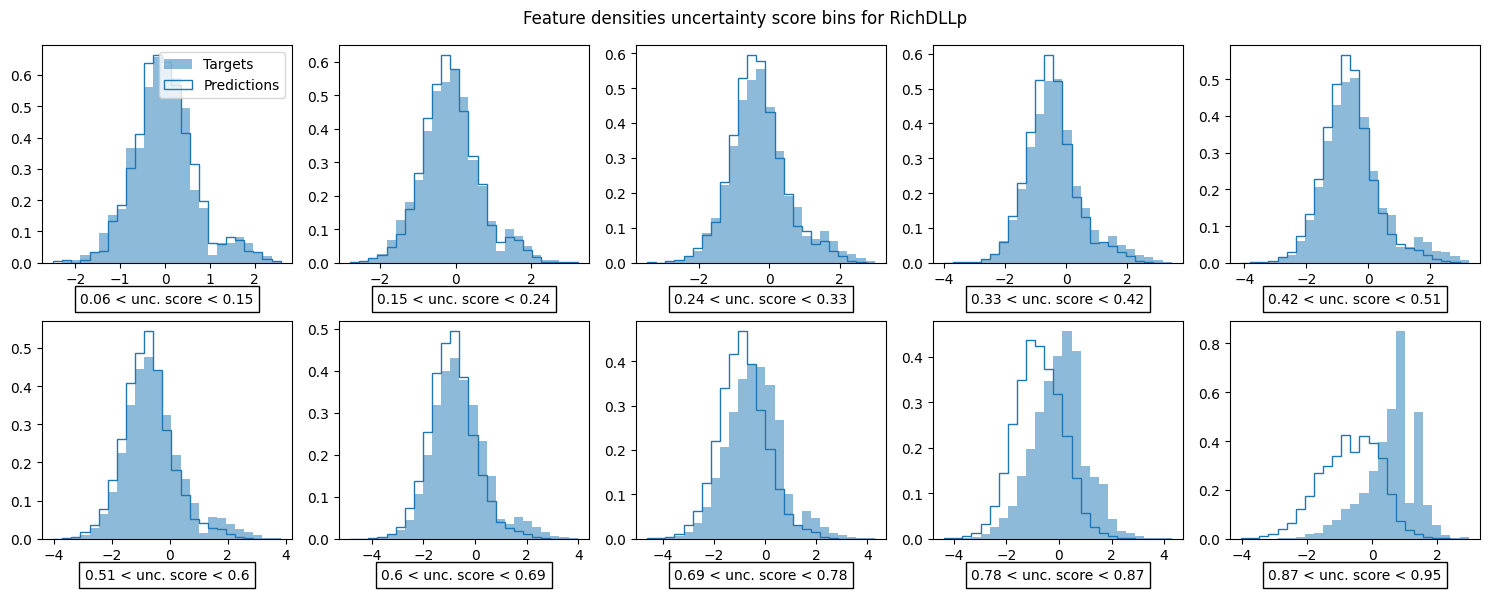

Jensen–Shannon distances:
0.07749233943918568, 0.05577593116837089, 0.06991495967998054, 0.08099453302987633, 0.09393587472288498, 0.10617372179394237, 0.12048099548570501, 0.17406625135206527, 0.2906973759829436, 0.47634414826689814
0.06 < unc. score < 0.15: Number of observations: 1153
0.15 < unc. score < 0.24: Number of observations: 4438
0.24 < unc. score < 0.33: Number of observations: 6767
0.33 < unc. score < 0.42: Number of observations: 9720
0.42 < unc. score < 0.51: Number of observations: 13626
0.51 < unc. score < 0.6: Number of observations: 17432
0.6 < unc. score < 0.69: Number of observations: 18766
0.69 < unc. score < 0.78: Number of observations: 15394
0.78 < unc. score < 0.87: Number of observations: 10854
0.87 < unc. score < 0.95: Number of observations: 1849


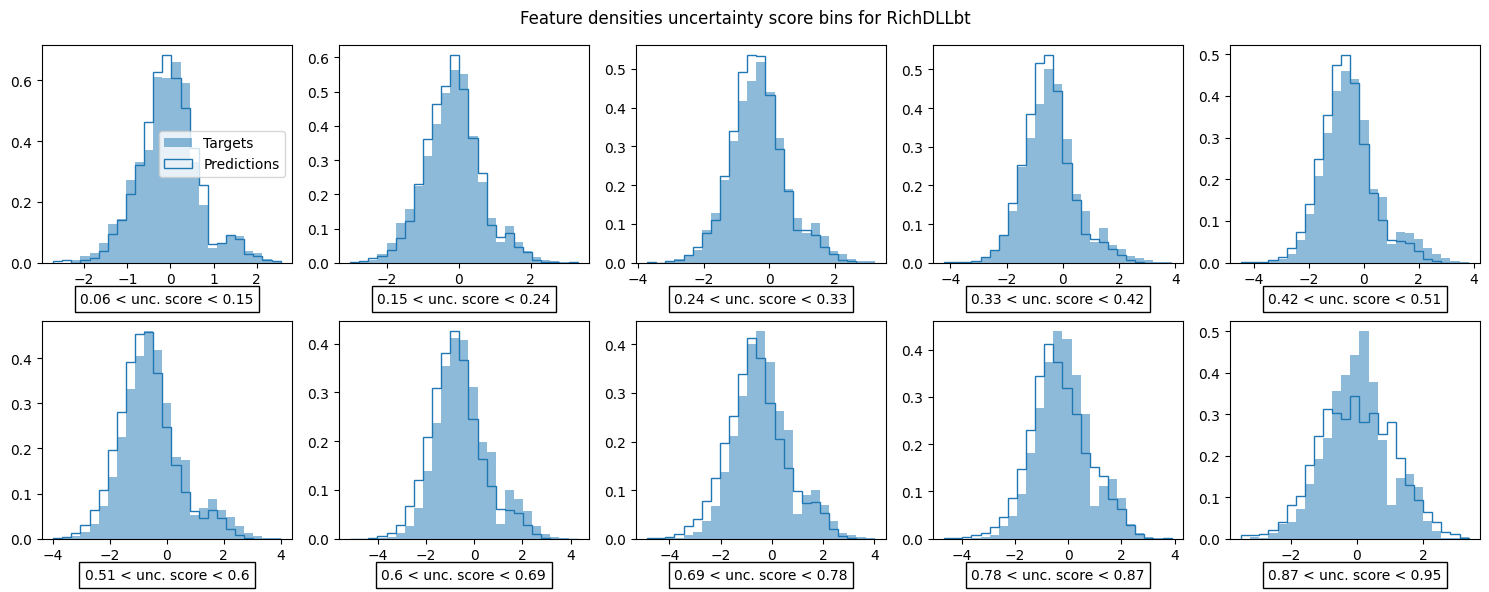

Jensen–Shannon distances:
0.07262361226704352, 0.06028858786177275, 0.06744593650440556, 0.08756241920129794, 0.09282198569908211, 0.10432090000702622, 0.12455256807635945, 0.11943106544693856, 0.11563620654149072, 0.1512603393270636


In [35]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', particle_index = i)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.869460506376588
Correlation coefficient for RichDLLk: 0.929176850095595
Correlation coefficient for RichDLLmu: 0.8004353993917273
Correlation coefficient for RichDLLp: 0.8153144206366202
Correlation coefficient for RichDLLbt: 0.941587706592232


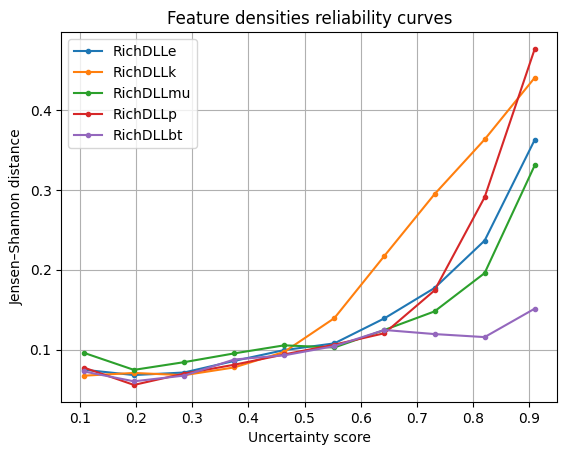

In [36]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')

#### Quantile bins

0.06 < unc. score < 0.3: Number of observations: 10000
0.3 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.47: Number of observations: 10000
0.47 < unc. score < 0.53: Number of observations: 10000
0.53 < unc. score < 0.58: Number of observations: 10000
0.58 < unc. score < 0.63: Number of observations: 10000
0.63 < unc. score < 0.68: Number of observations: 10000
0.68 < unc. score < 0.73: Number of observations: 10000
0.73 < unc. score < 0.79: Number of observations: 10000
0.79 < unc. score < 0.95: Number of observations: 9999


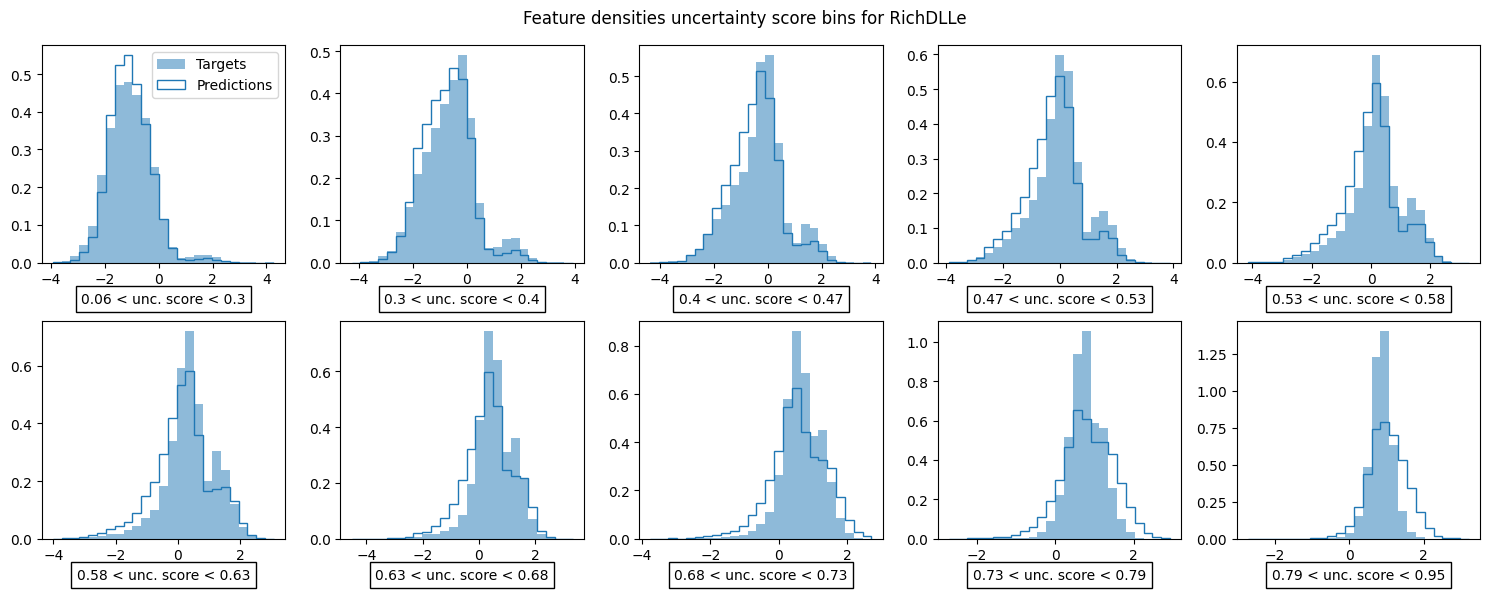

Jensen–Shannon distances:
0.06126119244349043, 0.08146873212985078, 0.09536950864480845, 0.10751188167155777, 0.1112381502172762, 0.12702849234720326, 0.14701593939577998, 0.1664771497763657, 0.1988949103766321, 0.2577368127644071
0.06 < unc. score < 0.3: Number of observations: 10000
0.3 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.47: Number of observations: 10000
0.47 < unc. score < 0.53: Number of observations: 10000
0.53 < unc. score < 0.58: Number of observations: 10000
0.58 < unc. score < 0.63: Number of observations: 10000
0.63 < unc. score < 0.68: Number of observations: 10000
0.68 < unc. score < 0.73: Number of observations: 10000
0.73 < unc. score < 0.79: Number of observations: 10000
0.79 < unc. score < 0.95: Number of observations: 9999


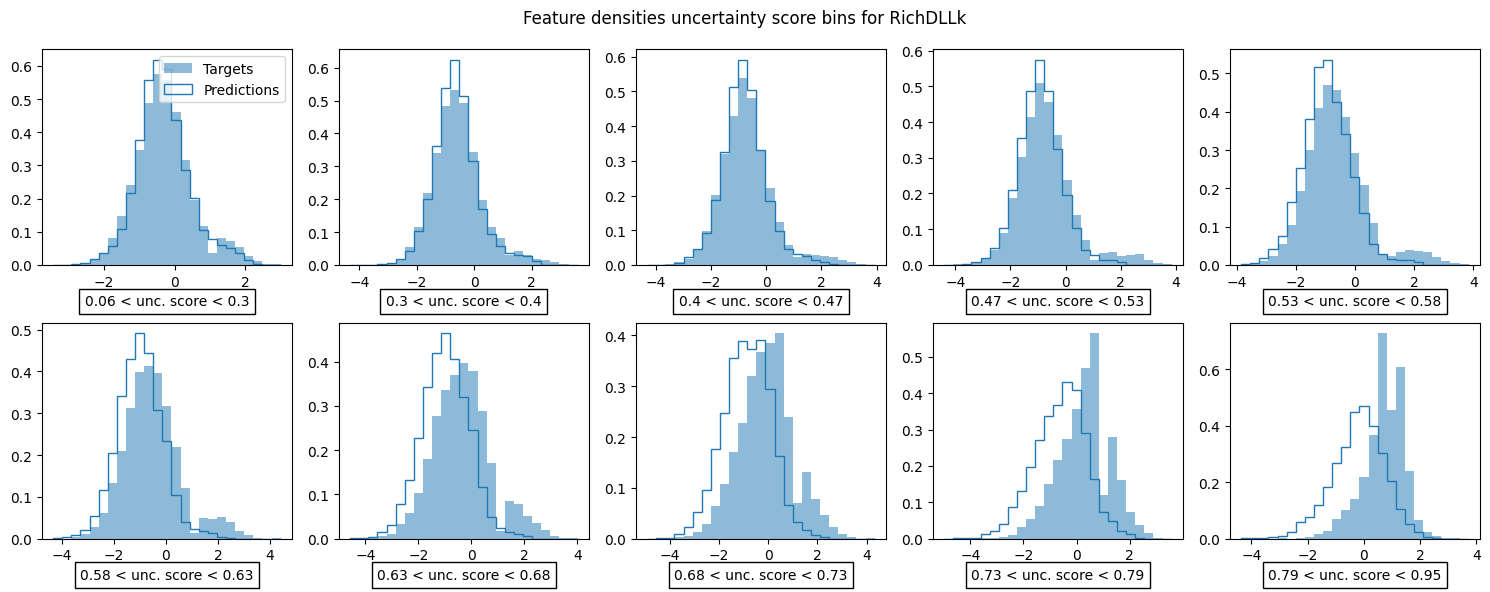

Jensen–Shannon distances:
0.06478012455856125, 0.0735559271079229, 0.08507060683868593, 0.11929803643457558, 0.13734222789349745, 0.18470789825693518, 0.23465501696621857, 0.2726292670143744, 0.32569171264208696, 0.37632240726011773
0.06 < unc. score < 0.3: Number of observations: 10000
0.3 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.47: Number of observations: 10000
0.47 < unc. score < 0.53: Number of observations: 10000
0.53 < unc. score < 0.58: Number of observations: 10000
0.58 < unc. score < 0.63: Number of observations: 10000
0.63 < unc. score < 0.68: Number of observations: 10000
0.68 < unc. score < 0.73: Number of observations: 10000
0.73 < unc. score < 0.79: Number of observations: 10000
0.79 < unc. score < 0.95: Number of observations: 9999


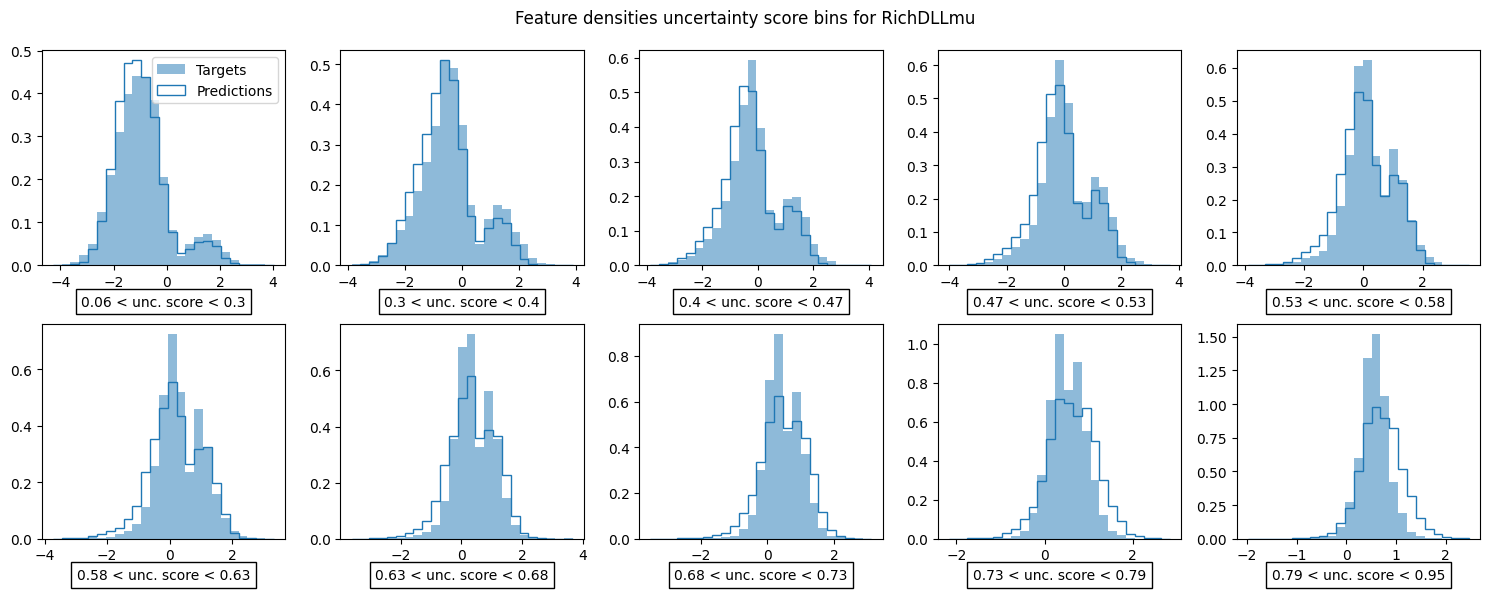

Jensen–Shannon distances:
0.07174164760249356, 0.09539179654783961, 0.09642825352005664, 0.1093218574462137, 0.10153097442903786, 0.12095760076938115, 0.12835189850046275, 0.14200495350835873, 0.16607416869755676, 0.21401222225038383
0.06 < unc. score < 0.3: Number of observations: 10000
0.3 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.47: Number of observations: 10000
0.47 < unc. score < 0.53: Number of observations: 10000
0.53 < unc. score < 0.58: Number of observations: 10000
0.58 < unc. score < 0.63: Number of observations: 10000
0.63 < unc. score < 0.68: Number of observations: 10000
0.68 < unc. score < 0.73: Number of observations: 10000
0.73 < unc. score < 0.79: Number of observations: 10000
0.79 < unc. score < 0.95: Number of observations: 9999


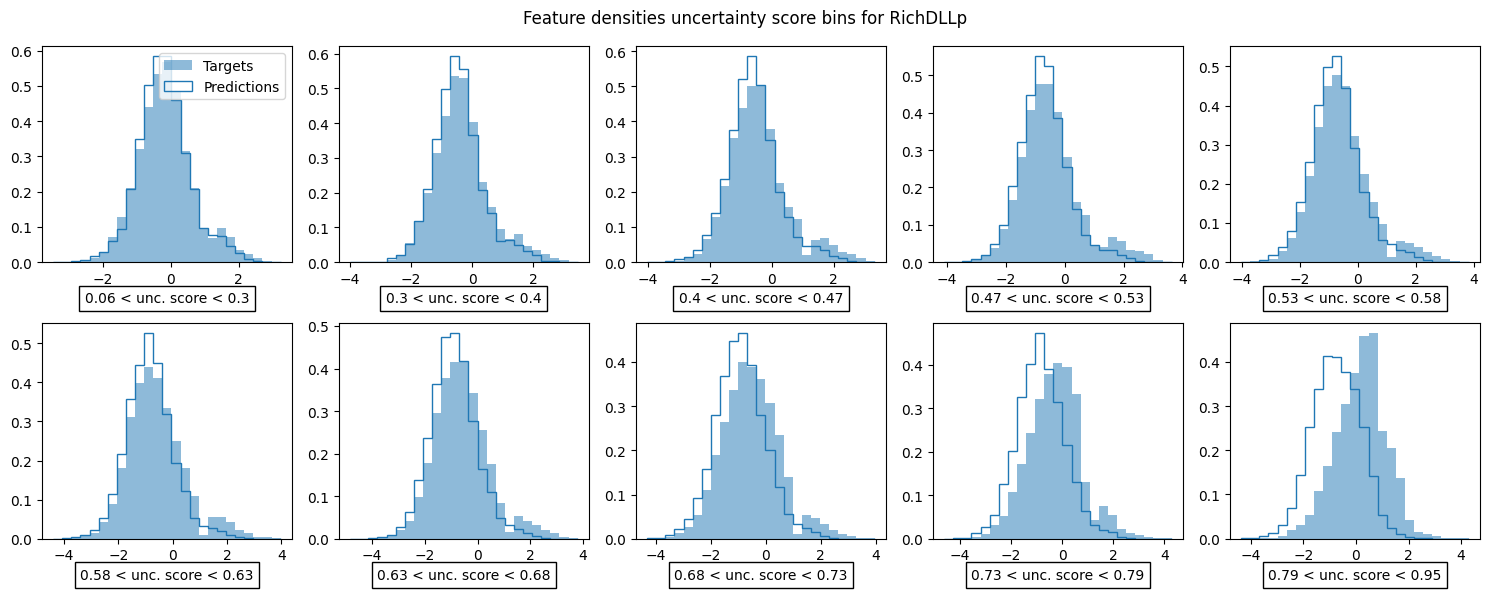

Jensen–Shannon distances:
0.054423848907559975, 0.07511153105627617, 0.09730439381581131, 0.10240802977802814, 0.10276561081752343, 0.11851904732912376, 0.1301481868446625, 0.15683680170700023, 0.2073951209767055, 0.336666568303894
0.06 < unc. score < 0.3: Number of observations: 10000
0.3 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.47: Number of observations: 10000
0.47 < unc. score < 0.53: Number of observations: 10000
0.53 < unc. score < 0.58: Number of observations: 10000
0.58 < unc. score < 0.63: Number of observations: 10000
0.63 < unc. score < 0.68: Number of observations: 10000
0.68 < unc. score < 0.73: Number of observations: 10000
0.73 < unc. score < 0.79: Number of observations: 10000
0.79 < unc. score < 0.95: Number of observations: 9999


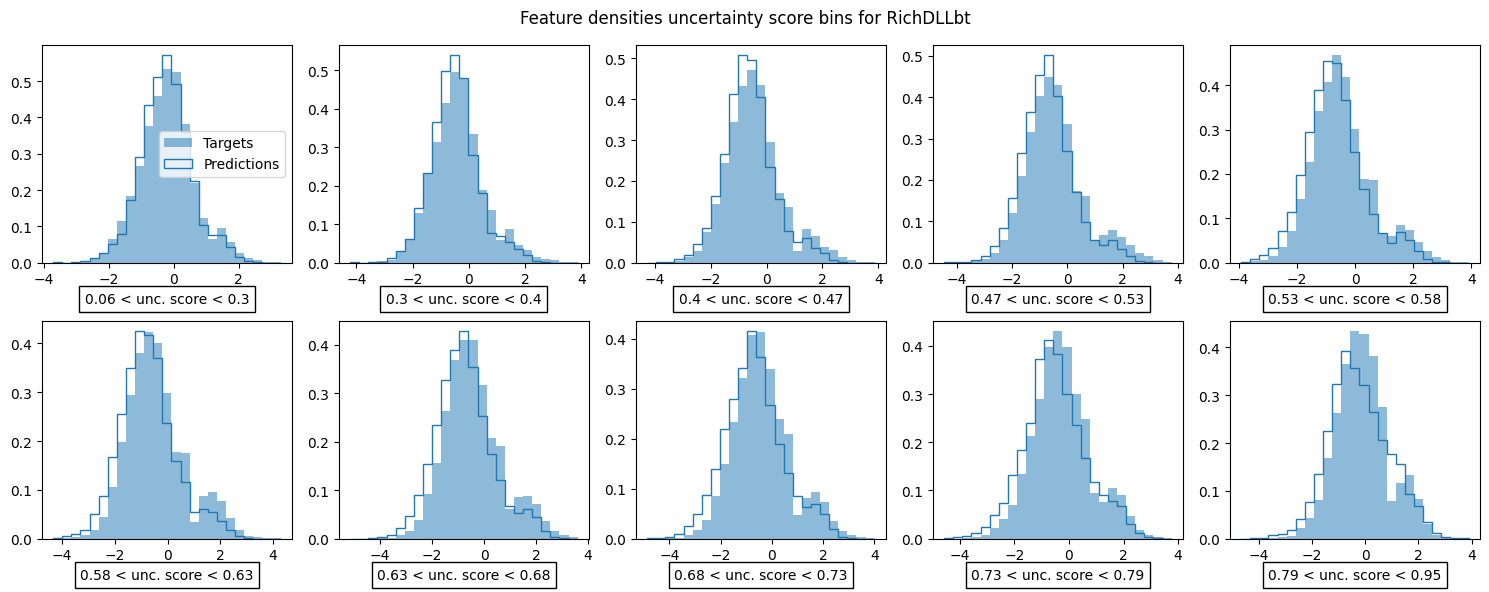

Jensen–Shannon distances:
0.055338720947108656, 0.08105210826464163, 0.09546906405330625, 0.10554698020374807, 0.10159825656593108, 0.11526010360633128, 0.12028011910998579, 0.12179009947393574, 0.10858793257120532, 0.12077745775599949


In [31]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', 'quantiles', particle_index = i)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.9397286558946981
Correlation coefficient for RichDLLk: 0.9374458256388165
Correlation coefficient for RichDLLmu: 0.9199777088480217
Correlation coefficient for RichDLLp: 0.860356292087936
Correlation coefficient for RichDLLbt: 0.9063171048915518


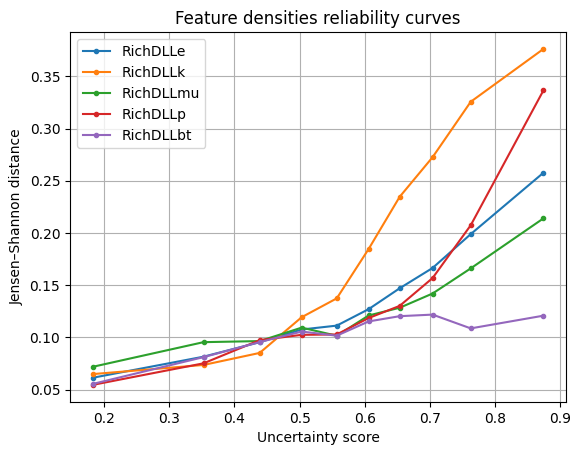

In [32]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')

## Uncertainty heatmaps

In [ ]:
def uncertainty_scatter_plot_fd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  plt.title('Feature densities heatmap')
  plt.scatter(momentum, eta, .1, uncertainties, cmap='inferno')
  plt.colorbar(label='Uncertainty score')
  plt.xlabel('Momentum')
  plt.ylabel('Eta')
  plt.show()

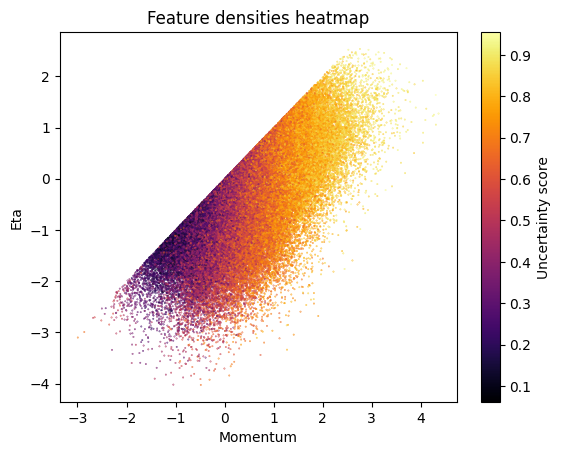

In [ ]:
uncertainty_scatter_plot_fd(x_sample, fd_uncertainty_normalized)

In [ ]:
def uncertainty_hist2d_fd(x_real, uncertainties, n_bins=100):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  momentum_edges, eta_edges = np.histogram2d(momentum, eta, n_bins)[1:]
  momentum_indices = np.digitize(momentum, momentum_edges)
  eta_indices = np.digitize(eta, eta_edges)

  heatmap = []

  for i in range(1, n_bins + 1):
    row = []
    for j in range(1, n_bins + 1):
      row += [uncertainties[(momentum_indices == j) & (eta_indices == i)].mean()]
    heatmap += [row]

  plt.title('Feature densities heatmap')
  plt.imshow(heatmap[::-1], 'inferno')
  plt.colorbar(label='Uncertainty score')
  plt.xlabel('Momentum')
  plt.ylabel('Eta')
  plt.show()

<ipython-input-161-3fbcaf20f6ee>:14: RuntimeWarning: Mean of empty slice.
  row += [uncertainties[(momentum_indices == j) & (eta_indices == i)].mean()]


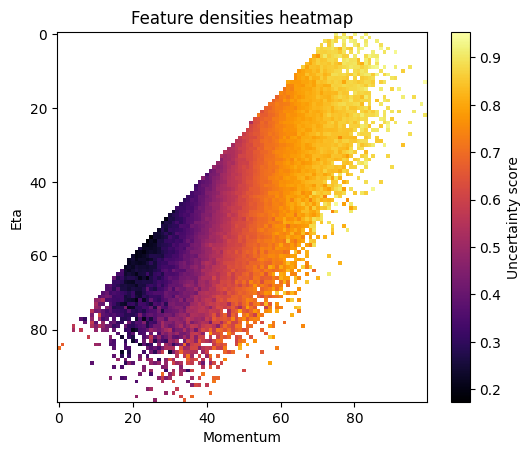

In [ ]:
uncertainty_hist2d_fd(x_sample, fd_uncertainty_normalized)

In [ ]:
def uncertainty_scatter_plot_mcd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  fig, axes = plt.subplots(2, 3, figsize=(11, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    ax.set_title(DLL_COLUMNS[i])
    scatter = ax.scatter(momentum, eta, .1, uncertainties[:, i], cmap='inferno')
    plt.colorbar(scatter, label='Uncertainty score')
    ax.set_xlabel('Momentum')
    ax.set_ylabel('Eta')

  plt.suptitle('MCD heatmaps')
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

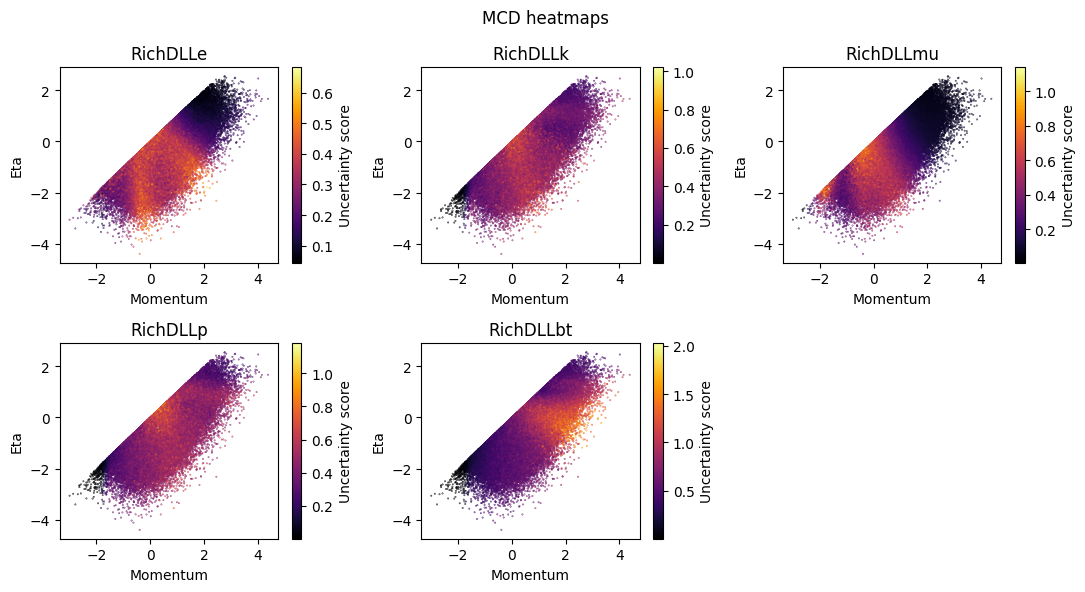

In [ ]:
uncertainty_scatter_plot_mcd(x_sample, mcd_uncertainty)

In [ ]:
def uncertainty_hist2d_mcd(x_real, uncertainties, n_bins=100):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  fig, axes = plt.subplots(2, 3, figsize=(11, 6))

  for ax_index, ax in enumerate(axes.flatten()[:-1]):
    momentum_edges, eta_edges = np.histogram2d(momentum, eta, n_bins)[1:]
    momentum_indices = np.digitize(momentum, momentum_edges)
    eta_indices = np.digitize(eta, eta_edges)

    heatmap = []

    for i in range(1, n_bins + 1):
      row = []
      for j in range(1, n_bins + 1):
        row += [uncertainties[(momentum_indices == j) & (eta_indices == i), ax_index].mean()]
      heatmap += [row]

    ax.set_title(DLL_COLUMNS[ax_index])
    image = ax.imshow(heatmap[::-1], 'inferno')
    plt.colorbar(image, label='Uncertainty score')
    ax.set_xlabel('Momentum')
    ax.set_ylabel('Eta')

  plt.suptitle('MCD heatmaps')
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

<ipython-input-172-8b6365313fe6>:17: RuntimeWarning: Mean of empty slice.
  row += [uncertainties[(momentum_indices == j) & (eta_indices == i), ax_index].mean()]


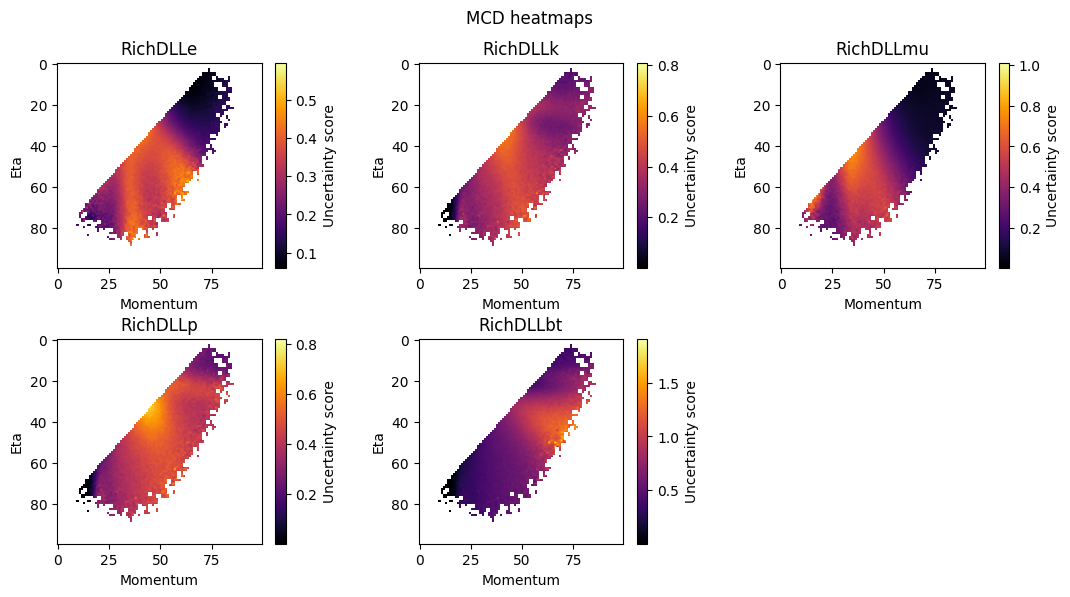

In [ ]:
uncertainty_hist2d_mcd(x_sample, mcd_uncertainty)

# Efficiency plots

In [ ]:
def select_threshold(feature, quantile=0.1):
    return np.quantile(feature, quantile)

def efficiency_bins(targets, threshold, particle_index):
    def compute_efficiency(y):
        return (y > threshold).mean()

    def compute_error(y):
        err = (y < threshold).sum() * (y > threshold).sum() / y.size**3
        return np.sqrt(err)

    efficiencies = []
    errors = []

    for target in targets:
        eff = compute_efficiency(target[:, particle_index])
        err = compute_error(target[:, particle_index])

        efficiencies.append(eff)
        errors.append(err)

    return efficiencies, errors

def compute_bin_indices(data, n_bins):
  bin_edges = np.linspace(data.min(), data.max(), n_bins + 1)
  indices = np.digitize(data, bin_edges)
  return indices

def plot_efficiencies(y_sample, t_generated, uncertainties, quantiles, n_bins=10, dll_columns=DLL_COLUMNS):
  y_sample = np.array(y_sample)
  t_generated = np.array(t_generated)
  uncertainties = np.array(uncertainties)

  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  indices = compute_bin_indices(uncertainties, n_bins)

  bins_targets = [t_generated[indices == i] for i in range(1, n_bins + 1)]
  bins_likelihoods = [uncertainties[indices == i].mean() for i in range(1, n_bins + 1)]

  for idx, ax in zip(range(5), axes.flatten()):
      for quantile in quantiles:
          threshold = select_threshold(y_sample[:, idx], quantile)
          eff, err = efficiency_bins(bins_targets, threshold, idx)

          plot = ax.plot(bins_likelihoods, eff, '.-', label=f'Quantile = {int(quantile * 100)}%')
          ax.errorbar(bins_likelihoods, eff, err, color=plot[0].get_color())

      ax.set_title(dll_columns[idx])
      ax.set_axisbelow(True)
      ax.grid()
      ax.set_xlabel("Bin likelihood")
      ax.set_ylabel("Efficiency")

  axes[-1, -1].axis(False)
  handles, labels = ax.get_legend_handles_labels()
  plt.legend(handles, labels, loc='upper left')

  plt.tight_layout()
  plt.show()

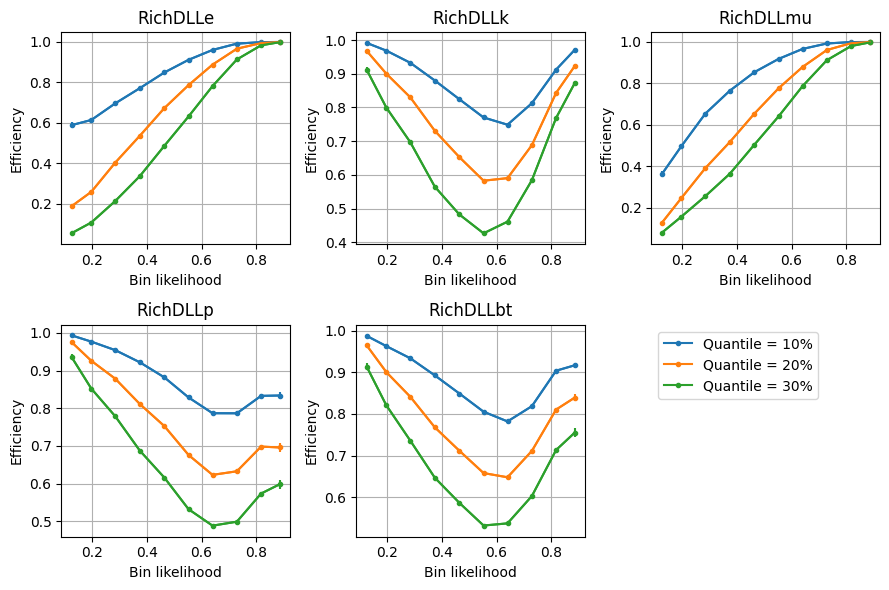

In [ ]:
plot_efficiencies(y_sample, t_generated, fd_uncertainty_normalized, [.1, .2, .3])

# Archived

#### FD with integration method


In [ ]:
fd_uncertainty_integration, _ = fd_evaluate_model(model, x_sample, known_embeddings=train_embeddings, n_fit_samples=100,
                                                  likelihood_method='integration')

print('Feature Densities using INTEGRATION uncertainty score for x_sample:')
fd_uncertainty_integration

Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 9s 3ms/step
Estimating sample's feature densities


100%|██████████| 100000/100000 [09:40<00:00, 172.17it/s]


Feature Densities using INTEGRATION uncertainty score for x_sample:


<tf.Tensor: shape=(100000,), dtype=float64, numpy=
array([0.99166736, 0.99320438, 0.98483132, ..., 0.98967961, 0.99608143,
       0.99588692])>

In [ ]:
# Save FD uncertainties with integration
np.save(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy', fd_uncertainty_integration)

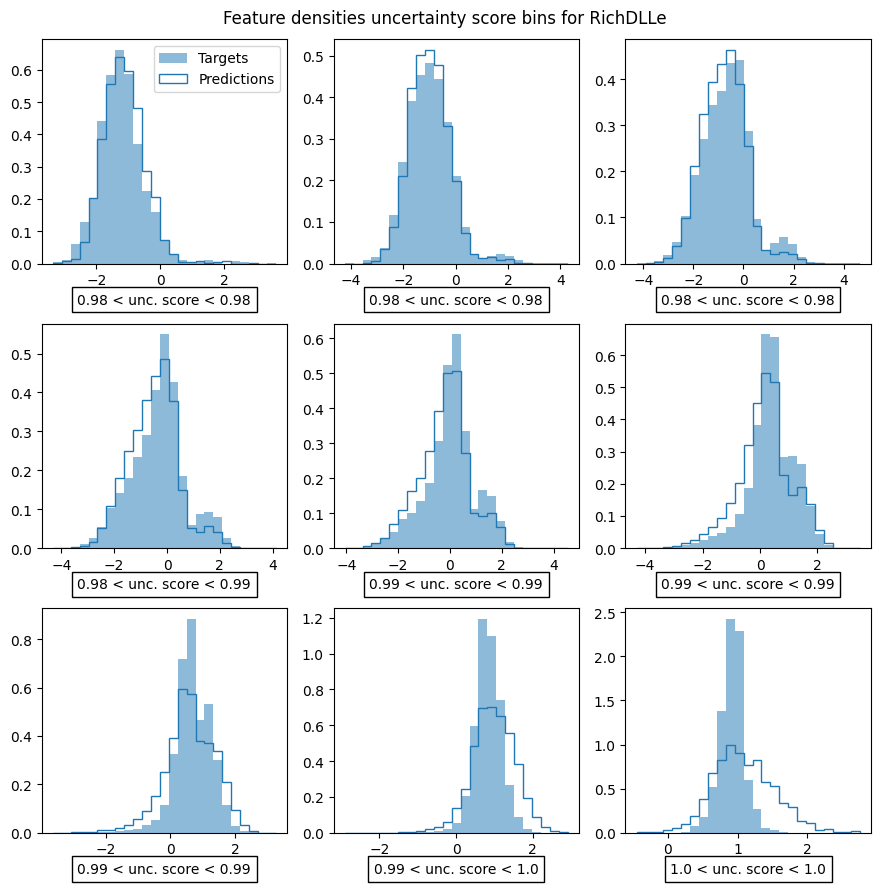

Jensen–Shannon distances:
0.09622084580538806, 0.0585183208196027, 0.07431106037785432, 0.09173176860875591, 0.09969241943001567, 0.1289956595370403, 0.1652380894043553, 0.23538475012621202, 0.37240579948854996


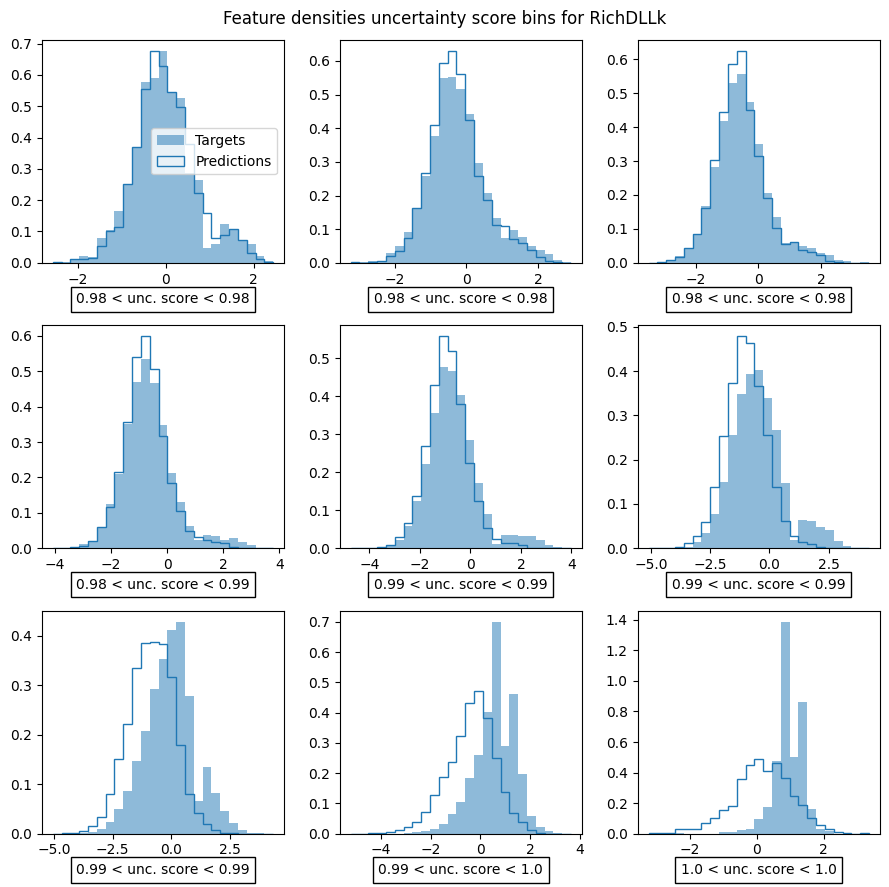

Jensen–Shannon distances:
0.08371077511448784, 0.0654720960520344, 0.05653954859424112, 0.08536574793440575, 0.12179464150396475, 0.19473439847731874, 0.27741588916878446, 0.36904235257402945, 0.4543678655925674


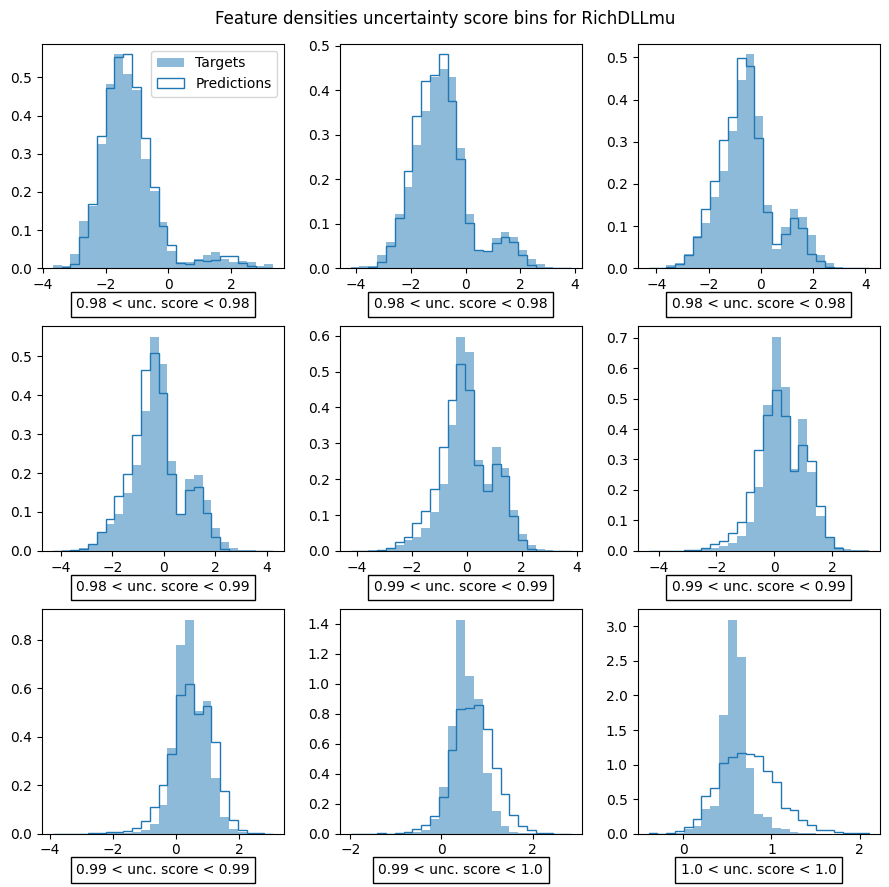

Jensen–Shannon distances:
0.08320841671858444, 0.06635888091019594, 0.08031478887903035, 0.08909623357918102, 0.09709237328152125, 0.11220610235831453, 0.14084113348506, 0.20008794857001014, 0.33758575031583343


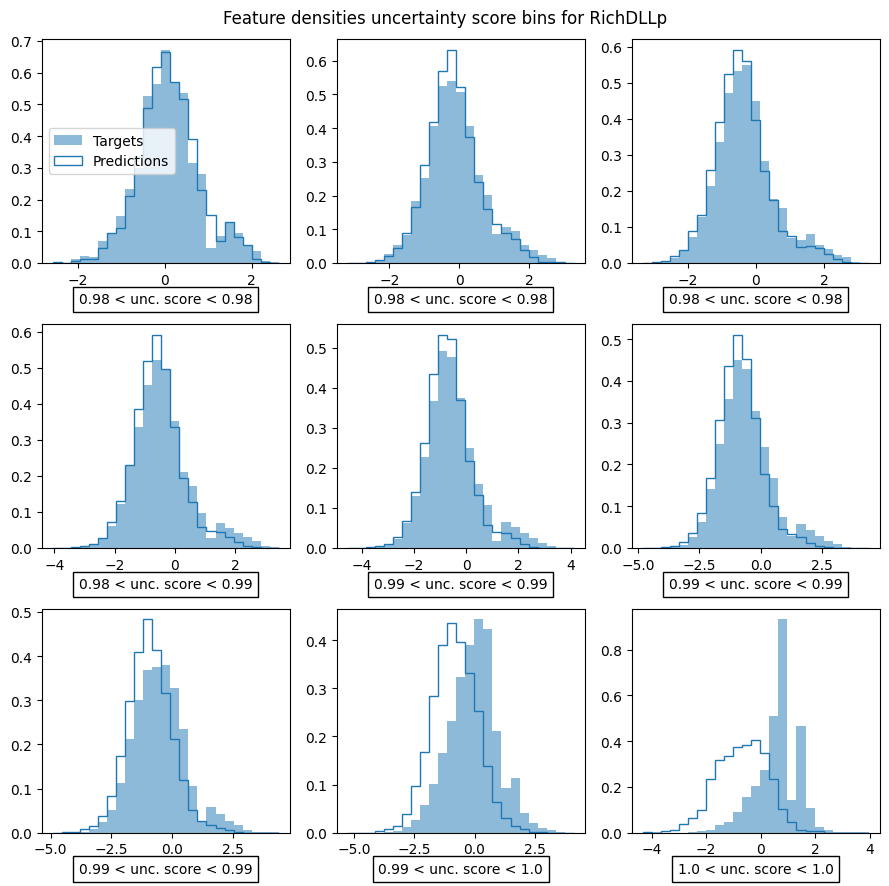

Jensen–Shannon distances:
0.07744682746742482, 0.06820153217264702, 0.07114998976382521, 0.08848384543658083, 0.09976903628186125, 0.1156986940602862, 0.15394968716591595, 0.28277369434794486, 0.49574636685905726


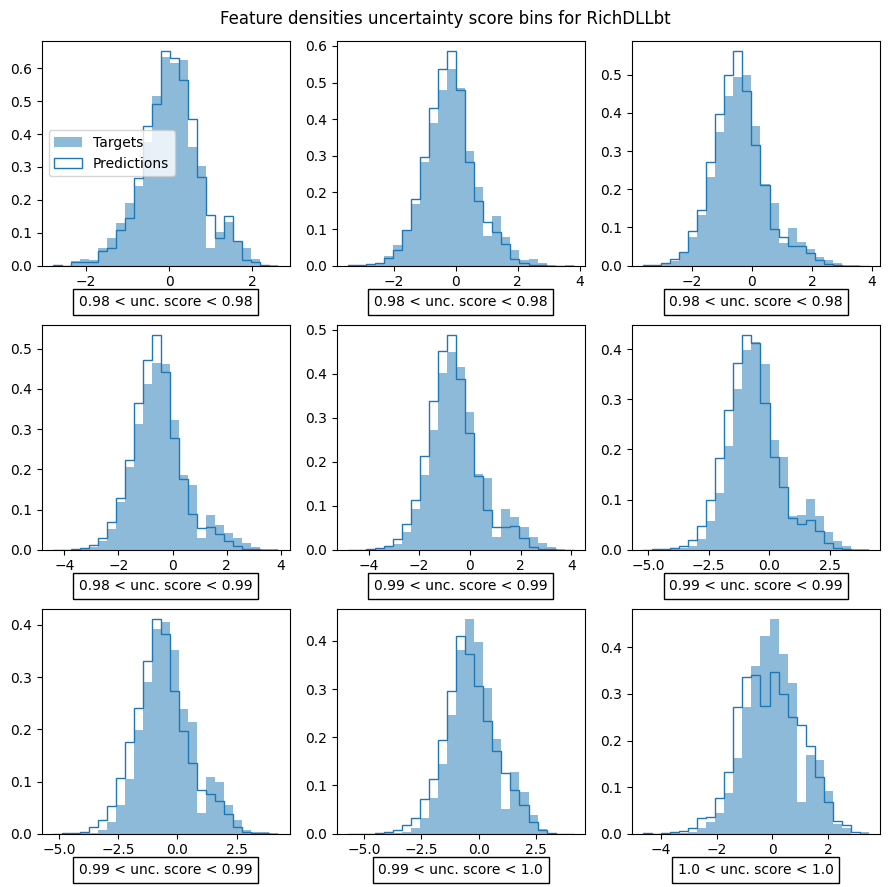

Jensen–Shannon distances:
0.08230790301719008, 0.07236818519397839, 0.07654665836042317, 0.09328260423021431, 0.104209952407771, 0.11565582126353942, 0.12169049182965685, 0.11879987567474574, 0.14639536458260857


In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_integration, 'Feature densities', particle_index = i, n_rows = 3, n_cols = 3)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.845066837334593
Correlation coefficient for RichDLLk: 0.9224163337708419
Correlation coefficient for RichDLLmu: 0.825405229820007
Correlation coefficient for RichDLLp: 0.8058483879419905
Correlation coefficient for RichDLLbt: 0.9469326100625362


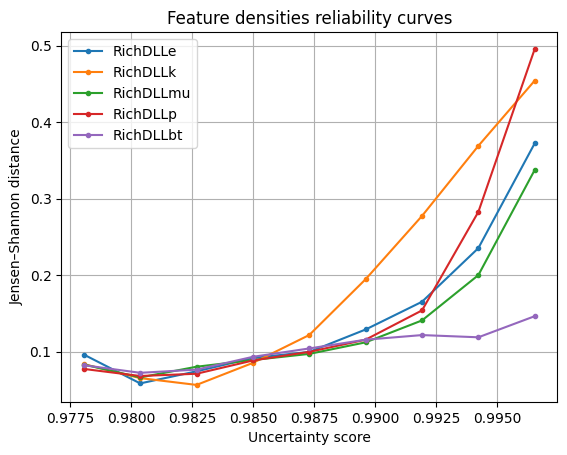

In [ ]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')

### Generation of FD embeddings

In [ ]:
# from feature_densities.feature_density_evaluator import create_embeddings_model
# embeddings_model = create_embeddings_model(model)

In [ ]:
# train_embeddings, train_predictions = embeddings_model.predict(dataset['feats_train'])

In [ ]:
# test_embeddings, test_predictions = embeddings_model.predict(dataset['feats_val'])

In [ ]:
# !rm -r embeddings
# !mkdir embeddings

# np.save(embeddings_dir + f'{PARTICLE}_train_embeddings.npy', train_embeddings)
# np.save(embeddings_dir + f'{PARTICLE}_train_predictions.npy', train_predictions)
# np.save(embeddings_dir + f'{PARTICLE}_test_embeddings.npy', test_embeddings)
# np.save(embeddings_dir + f'{PARTICLE}_test_predictions.npy', test_predictions)